In [1]:
import kagglehub
dataset_path = kagglehub.dataset_download("sunilthite/ovarian-cancer-classification-dataset")

print("Path to dataset files:", dataset_path)

/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/conite/.cache/kagglehub/datasets/sunilthite/ovarian-cancer-classification-dataset/versions/1


In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim         
import os, sys
from matplotlib import pyplot as plt

import json, logging
PROJECT_ROOT = os.path.abspath(os.path.join("../../"))
sys.path.append(PROJECT_ROOT)

from src.uncertainty_Quantification.helpers  import get_device, rotate_img, one_hot_embedding
from src.uncertainty_Quantification.train import train_model, train_deep_ensemble, get_dataloader
from src.uncertainty_Quantification.test import evaluate_model, evaluate_deep_ensemble, evaluate_mc_dropout
from src.uncertainty_Quantification.models import SingleNetwork, MCDropoutNetwork
from utils.utils import enable_dropout, set_seed
from src.uncertainty_Quantification.losses import edl_mse_loss, edl_digamma_loss, edl_log_loss, relu_evidence
from src.uncertainty_Quantification.calibration import calibrate_model
from src.uncertainty_Quantification.models import MCDropoutNetwork, SingleNetwork
from src.uncertainty_Quantification.uncertainty_analysis import rejection_plot
from utils.utils import get_device, save_history
DEVICE = get_device()


In [4]:
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames[:1]:
        print(os.path.join(dirname, filename))
        

train_dir = os.path.join(dataset_path, "Train_Images")
test_dir = os.path.join(dataset_path, "Test_Images")

/home/conite/.cache/kagglehub/datasets/sunilthite/ovarian-cancer-classification-dataset/versions/1/mobilenet_model_224x224_30_10.h5
/home/conite/.cache/kagglehub/datasets/sunilthite/ovarian-cancer-classification-dataset/versions/1/Train_Images/LGSC/18690.png
/home/conite/.cache/kagglehub/datasets/sunilthite/ovarian-cancer-classification-dataset/versions/1/Train_Images/HGSC/3729.png
/home/conite/.cache/kagglehub/datasets/sunilthite/ovarian-cancer-classification-dataset/versions/1/Train_Images/EC/23912.png
/home/conite/.cache/kagglehub/datasets/sunilthite/ovarian-cancer-classification-dataset/versions/1/Train_Images/CC/4697.png
/home/conite/.cache/kagglehub/datasets/sunilthite/ovarian-cancer-classification-dataset/versions/1/Train_Images/MC/7491.png
/home/conite/.cache/kagglehub/datasets/sunilthite/ovarian-cancer-classification-dataset/versions/1/Test_Images/LGSC/16979.png
/home/conite/.cache/kagglehub/datasets/sunilthite/ovarian-cancer-classification-dataset/versions/1/Test_Images/HGSC/

Dataset Structure:
['Train_Images', 'mobilenet_model_224x224_30_10.h5', 'Test_Images']

Train Categories: ['LGSC', 'HGSC', 'EC', 'CC', 'MC']
Test Categories: ['LGSC', 'HGSC', 'EC', 'CC', 'MC']


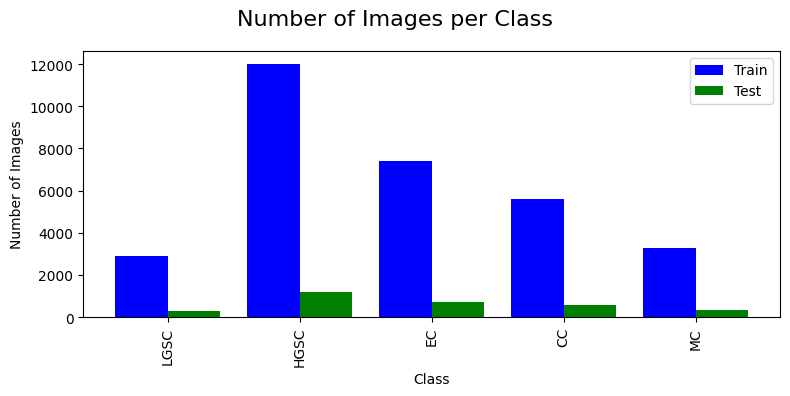

In [5]:
import os

print("Dataset Structure:")
print(os.listdir(dataset_path))

train_dir = os.path.join(dataset_path, "Train_Images")
test_dir = os.path.join(dataset_path, "Test_Images")

print("\nTrain Categories:", os.listdir(train_dir))
print("Test Categories:", os.listdir(test_dir))

train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)

train_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in train_classes]
test_counts = [len(os.listdir(os.path.join(test_dir, cls))) for cls in test_classes]

fig, ax = plt.subplots(figsize=(8, 4))
fig.suptitle("Number of Images per Class", fontsize=16)

width = 0.4 
x = np.arange(len(train_classes)) 
ax.bar(x - width/2, train_counts, width, label='Train', color='blue')
ax.bar(x + width/2, test_counts, width, label='Test', color='green')

ax.set_xlabel("Class")
ax.set_ylabel("Number of Images")
ax.set_xticks(x)
ax.set_xticklabels(train_classes, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

# Loda datasets

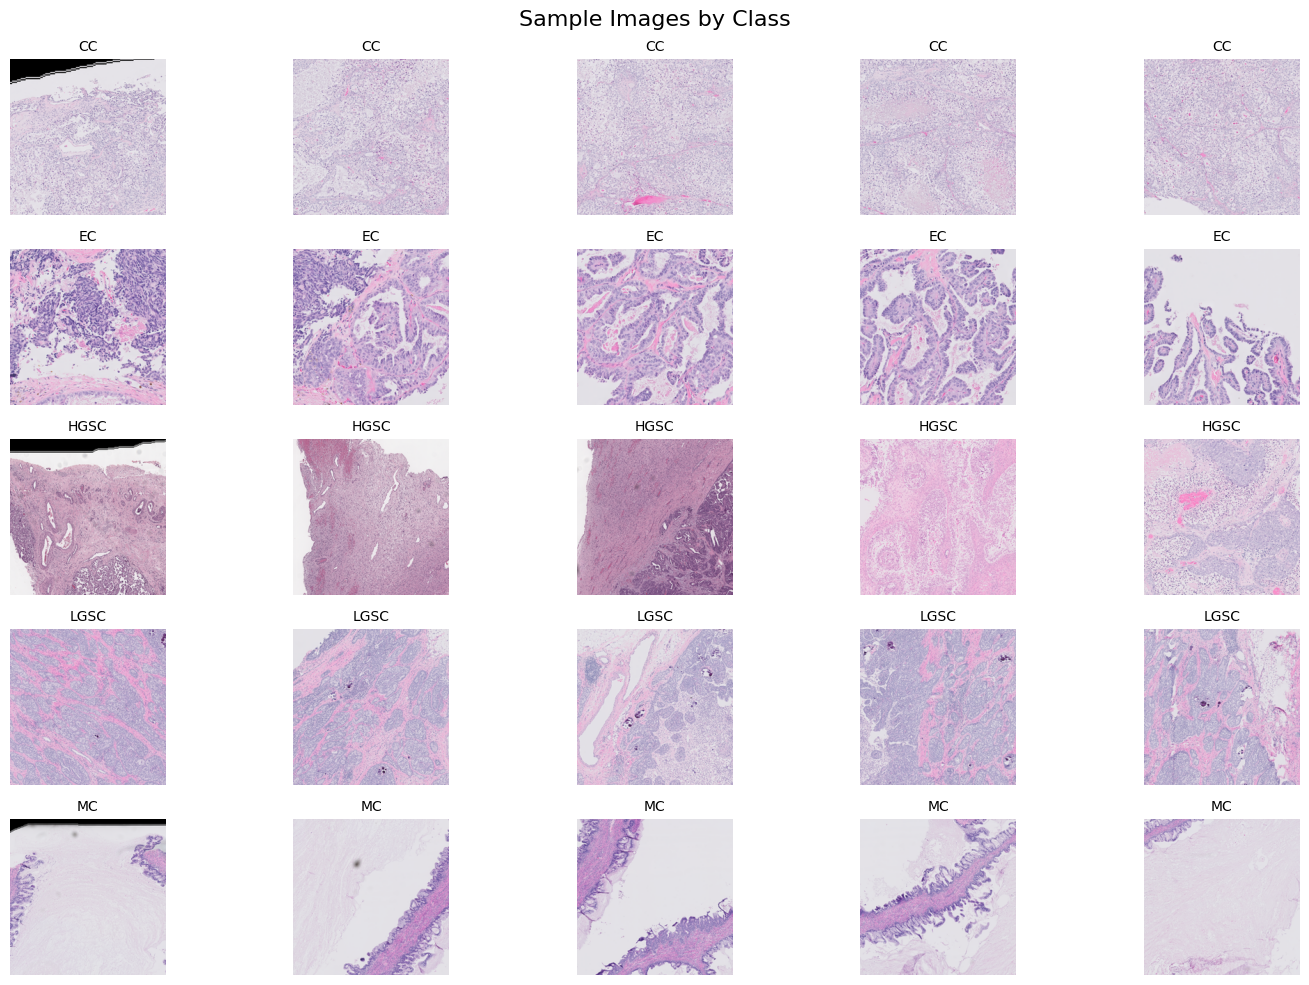

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from PIL import Image

# Define transformation (for visualization, we don't normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping
num_samples_per_class = 5

# Dictionary to store image paths per class
class_sample_indices = {cls: [] for cls in class_to_idx.keys()}

# Collect 5 image paths per class
for img_path, class_idx in train_dataset.samples:
    class_name = idx_to_class[class_idx]
    if len(class_sample_indices[class_name]) < num_samples_per_class:
        class_sample_indices[class_name].append(img_path)
    if all(len(lst) == num_samples_per_class for lst in class_sample_indices.values()):
        break

# Plot images
fig, axs = plt.subplots(len(class_sample_indices), num_samples_per_class, figsize=(15, 10))
fig.suptitle("Sample Images by Class", fontsize=16)

for class_idx, (class_name, img_paths) in enumerate(class_sample_indices.items()):
    for img_idx, img_path in enumerate(img_paths):
        img = Image.open(img_path)
        axs[class_idx, img_idx].imshow(img)
        axs[class_idx, img_idx].axis("off")
        axs[class_idx, img_idx].set_title(class_name, fontsize=10)  # Add class name as title

plt.tight_layout()
plt.show()


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

full_train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
num_train_samples = len(full_train_dataset)
indices = np.arange(num_train_samples)

train_idx, cal_val_idx = train_test_split(indices, test_size=0.15, random_state=42)
cal_idx, val_idx = train_test_split(cal_val_idx, test_size=0.25, random_state=42)  
# 25% of 15% = 3.75% of total

train_dataset = Subset(full_train_dataset, train_idx)
cal_dataset = Subset(full_train_dataset, cal_idx)
val_dataset = Subset(full_train_dataset, val_idx)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

print(f"Dataset Sizes: Train={len(train_dataset)}, Cal={len(cal_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

batch_size = 32
num_workers = min(4, os.cpu_count() //2)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
cal_loader = DataLoader(cal_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)


Dataset Sizes: Train=26522, Cal=3510, Val=1171, Test=3082


**Feacture extraction**

In [ ]:
from src.preprocessing.feature_extraction import extract_features
from torchvision import models

resnet = models.resnet50(pretrained=True)
features_train, labels_train = extract_features(train_loader, resnet)
features_val, labels_val = extract_features(val_loader, resnet)
features_cal, labels_cal = extract_features(cal_loader, resnet)
features_test, labels_test = extract_features(test_loader, resnet)
SAVE_FEATURES_PATH = os.path.join(PROJECT_ROOT, "outputs/feature_extraction/")
os.makedirs(SAVE_FEATURES_PATH, exist_ok=True)
np.savez(f"{SAVE_FEATURES_PATH}/resnet50_features_ovariancancer.npz",
         train=features_train, train_labels=labels_train,
         val=features_val, val_labels=labels_val,
         cal=features_cal, cal_labels=labels_cal,
         test=features_test, test_labels=labels_test)


In [6]:
set_seed(42)
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
PATIENCE =10
ENSEMBLE_SIZE = 5
DROPOUT_RATE = 0.4

# Load DataLoaders
typeofdata = "resnet50_features_ovariancancer"
train_loader = get_dataloader("train", BATCH_SIZE, typeofdata)
val_loader = get_dataloader("val", BATCH_SIZE, typeofdata)
test_loader = get_dataloader("test", BATCH_SIZE, typeofdata)

# Initialize model
input_dim = train_loader.dataset.tensors[0].shape[1]
num_classes = len(set(train_loader.dataset.tensors[1].numpy()))
print(f"Input Dimension: {input_dim}, Number of Classes: {num_classes}")


######################
#   Single Network   #
######################
logging.info("Training Single Network...")
single_net = SingleNetwork(input_dim, num_classes).to(DEVICE)
optimizer = torch.optim.Adam(single_net.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
train_model(single_net, train_loader, val_loader, criterion, optimizer, EPOCHS, "OvarianSingleNetwork", PATIENCE)


Input Dimension: 1000, Number of Classes: 5


INFO:OvarianSingleNetwork:Starting training for OvarianSingleNetwork


Training OvarianSingleNetwork for 50 epochs


Training OvarianSingleNetwork Epoch 1/50: 100%|██████████| 829/829 [00:03<00:00, 229.54it/s]
INFO:OvarianSingleNetwork:Epoch 1/50 | Train Loss: 930.0163 | Val Loss: 40.1717 | Val Acc: 0.5841 | Val F1: 0.5601 | Val Recall: 0.5841 | Val Precision: 0.5845
INFO:OvarianSingleNetwork:Validation loss decreased to 40.1717. Saving model...


Epoch 1/50 | Train Loss: 930.0163 | Val Loss: 40.1717 | Val Acc: 0.5841 | Val F1: 0.5601 | Val Recall: 0.5841 | Val Precision: 0.5845


Training OvarianSingleNetwork Epoch 2/50: 100%|██████████| 829/829 [00:03<00:00, 232.86it/s]
INFO:OvarianSingleNetwork:Epoch 2/50 | Train Loss: 789.4030 | Val Loss: 36.2999 | Val Acc: 0.5978 | Val F1: 0.6009 | Val Recall: 0.5978 | Val Precision: 0.6196
INFO:OvarianSingleNetwork:Validation loss decreased to 36.2999. Saving model...


Epoch 2/50 | Train Loss: 789.4030 | Val Loss: 36.2999 | Val Acc: 0.5978 | Val F1: 0.6009 | Val Recall: 0.5978 | Val Precision: 0.6196


Training OvarianSingleNetwork Epoch 3/50: 100%|██████████| 829/829 [00:02<00:00, 366.42it/s]
INFO:OvarianSingleNetwork:Epoch 3/50 | Train Loss: 721.7005 | Val Loss: 34.5220 | Val Acc: 0.6200 | Val F1: 0.6164 | Val Recall: 0.6200 | Val Precision: 0.6274
INFO:OvarianSingleNetwork:Validation loss decreased to 34.5220. Saving model...


Epoch 3/50 | Train Loss: 721.7005 | Val Loss: 34.5220 | Val Acc: 0.6200 | Val F1: 0.6164 | Val Recall: 0.6200 | Val Precision: 0.6274


Training OvarianSingleNetwork Epoch 4/50: 100%|██████████| 829/829 [00:03<00:00, 242.98it/s]
INFO:OvarianSingleNetwork:Epoch 4/50 | Train Loss: 669.3576 | Val Loss: 33.4006 | Val Acc: 0.6422 | Val F1: 0.6385 | Val Recall: 0.6422 | Val Precision: 0.6560
INFO:OvarianSingleNetwork:Validation loss decreased to 33.4006. Saving model...


Epoch 4/50 | Train Loss: 669.3576 | Val Loss: 33.4006 | Val Acc: 0.6422 | Val F1: 0.6385 | Val Recall: 0.6422 | Val Precision: 0.6560


Training OvarianSingleNetwork Epoch 5/50: 100%|██████████| 829/829 [00:03<00:00, 225.37it/s]
INFO:OvarianSingleNetwork:Epoch 5/50 | Train Loss: 631.7568 | Val Loss: 31.1655 | Val Acc: 0.6840 | Val F1: 0.6827 | Val Recall: 0.6840 | Val Precision: 0.6862
INFO:OvarianSingleNetwork:Validation loss decreased to 31.1655. Saving model...


Epoch 5/50 | Train Loss: 631.7568 | Val Loss: 31.1655 | Val Acc: 0.6840 | Val F1: 0.6827 | Val Recall: 0.6840 | Val Precision: 0.6862


Training OvarianSingleNetwork Epoch 6/50: 100%|██████████| 829/829 [00:02<00:00, 316.76it/s]
INFO:OvarianSingleNetwork:Epoch 6/50 | Train Loss: 595.6661 | Val Loss: 31.0725 | Val Acc: 0.6763 | Val F1: 0.6760 | Val Recall: 0.6763 | Val Precision: 0.6871
INFO:OvarianSingleNetwork:Validation loss decreased to 31.0725. Saving model...


Epoch 6/50 | Train Loss: 595.6661 | Val Loss: 31.0725 | Val Acc: 0.6763 | Val F1: 0.6760 | Val Recall: 0.6763 | Val Precision: 0.6871


Training OvarianSingleNetwork Epoch 7/50: 100%|██████████| 829/829 [00:01<00:00, 425.29it/s]
INFO:OvarianSingleNetwork:Epoch 7/50 | Train Loss: 566.1466 | Val Loss: 31.1760 | Val Acc: 0.6789 | Val F1: 0.6728 | Val Recall: 0.6789 | Val Precision: 0.6894
INFO:OvarianSingleNetwork:No improvement for 1 epochs


Epoch 7/50 | Train Loss: 566.1466 | Val Loss: 31.1760 | Val Acc: 0.6789 | Val F1: 0.6728 | Val Recall: 0.6789 | Val Precision: 0.6894


Training OvarianSingleNetwork Epoch 8/50: 100%|██████████| 829/829 [00:03<00:00, 239.71it/s]
INFO:OvarianSingleNetwork:Epoch 8/50 | Train Loss: 537.7292 | Val Loss: 30.6358 | Val Acc: 0.6755 | Val F1: 0.6773 | Val Recall: 0.6755 | Val Precision: 0.6887
INFO:OvarianSingleNetwork:Validation loss decreased to 30.6358. Saving model...


Epoch 8/50 | Train Loss: 537.7292 | Val Loss: 30.6358 | Val Acc: 0.6755 | Val F1: 0.6773 | Val Recall: 0.6755 | Val Precision: 0.6887


Training OvarianSingleNetwork Epoch 9/50: 100%|██████████| 829/829 [00:03<00:00, 215.39it/s]
INFO:OvarianSingleNetwork:Epoch 9/50 | Train Loss: 512.8693 | Val Loss: 30.2807 | Val Acc: 0.6857 | Val F1: 0.6835 | Val Recall: 0.6857 | Val Precision: 0.7001
INFO:OvarianSingleNetwork:Validation loss decreased to 30.2807. Saving model...


Epoch 9/50 | Train Loss: 512.8693 | Val Loss: 30.2807 | Val Acc: 0.6857 | Val F1: 0.6835 | Val Recall: 0.6857 | Val Precision: 0.7001


Training OvarianSingleNetwork Epoch 10/50: 100%|██████████| 829/829 [00:03<00:00, 233.25it/s]
INFO:OvarianSingleNetwork:Epoch 10/50 | Train Loss: 488.6263 | Val Loss: 28.8196 | Val Acc: 0.7062 | Val F1: 0.7022 | Val Recall: 0.7062 | Val Precision: 0.7046
INFO:OvarianSingleNetwork:Validation loss decreased to 28.8196. Saving model...


Epoch 10/50 | Train Loss: 488.6263 | Val Loss: 28.8196 | Val Acc: 0.7062 | Val F1: 0.7022 | Val Recall: 0.7062 | Val Precision: 0.7046


Training OvarianSingleNetwork Epoch 11/50: 100%|██████████| 829/829 [00:02<00:00, 278.73it/s]
INFO:OvarianSingleNetwork:Epoch 11/50 | Train Loss: 463.5805 | Val Loss: 29.3349 | Val Acc: 0.7122 | Val F1: 0.7080 | Val Recall: 0.7122 | Val Precision: 0.7190
INFO:OvarianSingleNetwork:No improvement for 1 epochs


Epoch 11/50 | Train Loss: 463.5805 | Val Loss: 29.3349 | Val Acc: 0.7122 | Val F1: 0.7080 | Val Recall: 0.7122 | Val Precision: 0.7190


Training OvarianSingleNetwork Epoch 12/50: 100%|██████████| 829/829 [00:03<00:00, 252.40it/s]
INFO:OvarianSingleNetwork:Epoch 12/50 | Train Loss: 441.7981 | Val Loss: 28.3436 | Val Acc: 0.7096 | Val F1: 0.7122 | Val Recall: 0.7096 | Val Precision: 0.7176
INFO:OvarianSingleNetwork:Validation loss decreased to 28.3436. Saving model...


Epoch 12/50 | Train Loss: 441.7981 | Val Loss: 28.3436 | Val Acc: 0.7096 | Val F1: 0.7122 | Val Recall: 0.7096 | Val Precision: 0.7176


Training OvarianSingleNetwork Epoch 13/50: 100%|██████████| 829/829 [00:02<00:00, 389.93it/s]
INFO:OvarianSingleNetwork:Epoch 13/50 | Train Loss: 420.7686 | Val Loss: 30.4863 | Val Acc: 0.6943 | Val F1: 0.6959 | Val Recall: 0.6943 | Val Precision: 0.7034
INFO:OvarianSingleNetwork:No improvement for 1 epochs


Epoch 13/50 | Train Loss: 420.7686 | Val Loss: 30.4863 | Val Acc: 0.6943 | Val F1: 0.6959 | Val Recall: 0.6943 | Val Precision: 0.7034


Training OvarianSingleNetwork Epoch 14/50: 100%|██████████| 829/829 [00:02<00:00, 310.19it/s]
INFO:OvarianSingleNetwork:Epoch 14/50 | Train Loss: 398.2948 | Val Loss: 29.1042 | Val Acc: 0.7190 | Val F1: 0.7159 | Val Recall: 0.7190 | Val Precision: 0.7198
INFO:OvarianSingleNetwork:No improvement for 2 epochs


Epoch 14/50 | Train Loss: 398.2948 | Val Loss: 29.1042 | Val Acc: 0.7190 | Val F1: 0.7159 | Val Recall: 0.7190 | Val Precision: 0.7198


Training OvarianSingleNetwork Epoch 15/50: 100%|██████████| 829/829 [00:02<00:00, 358.28it/s]
INFO:OvarianSingleNetwork:Epoch 15/50 | Train Loss: 380.9857 | Val Loss: 28.9008 | Val Acc: 0.7250 | Val F1: 0.7212 | Val Recall: 0.7250 | Val Precision: 0.7245
INFO:OvarianSingleNetwork:No improvement for 3 epochs


Epoch 15/50 | Train Loss: 380.9857 | Val Loss: 28.9008 | Val Acc: 0.7250 | Val F1: 0.7212 | Val Recall: 0.7250 | Val Precision: 0.7245


Training OvarianSingleNetwork Epoch 16/50: 100%|██████████| 829/829 [00:02<00:00, 391.05it/s]
INFO:OvarianSingleNetwork:Epoch 16/50 | Train Loss: 362.8856 | Val Loss: 30.7253 | Val Acc: 0.6994 | Val F1: 0.7018 | Val Recall: 0.6994 | Val Precision: 0.7252
INFO:OvarianSingleNetwork:No improvement for 4 epochs


Epoch 16/50 | Train Loss: 362.8856 | Val Loss: 30.7253 | Val Acc: 0.6994 | Val F1: 0.7018 | Val Recall: 0.6994 | Val Precision: 0.7252


Training OvarianSingleNetwork Epoch 17/50: 100%|██████████| 829/829 [00:03<00:00, 214.52it/s]
INFO:OvarianSingleNetwork:Epoch 17/50 | Train Loss: 345.5060 | Val Loss: 29.4717 | Val Acc: 0.7208 | Val F1: 0.7201 | Val Recall: 0.7208 | Val Precision: 0.7253
INFO:OvarianSingleNetwork:No improvement for 5 epochs


Epoch 17/50 | Train Loss: 345.5060 | Val Loss: 29.4717 | Val Acc: 0.7208 | Val F1: 0.7201 | Val Recall: 0.7208 | Val Precision: 0.7253


Training OvarianSingleNetwork Epoch 18/50: 100%|██████████| 829/829 [00:05<00:00, 155.81it/s]
INFO:OvarianSingleNetwork:Epoch 18/50 | Train Loss: 331.8210 | Val Loss: 29.5711 | Val Acc: 0.7131 | Val F1: 0.7134 | Val Recall: 0.7131 | Val Precision: 0.7252
INFO:OvarianSingleNetwork:No improvement for 6 epochs


Epoch 18/50 | Train Loss: 331.8210 | Val Loss: 29.5711 | Val Acc: 0.7131 | Val F1: 0.7134 | Val Recall: 0.7131 | Val Precision: 0.7252


Training OvarianSingleNetwork Epoch 19/50: 100%|██████████| 829/829 [00:03<00:00, 242.76it/s]
INFO:OvarianSingleNetwork:Epoch 19/50 | Train Loss: 311.8937 | Val Loss: 31.1266 | Val Acc: 0.7208 | Val F1: 0.7181 | Val Recall: 0.7208 | Val Precision: 0.7243
INFO:OvarianSingleNetwork:No improvement for 7 epochs


Epoch 19/50 | Train Loss: 311.8937 | Val Loss: 31.1266 | Val Acc: 0.7208 | Val F1: 0.7181 | Val Recall: 0.7208 | Val Precision: 0.7243


Training OvarianSingleNetwork Epoch 20/50: 100%|██████████| 829/829 [00:03<00:00, 253.35it/s]
INFO:OvarianSingleNetwork:Epoch 20/50 | Train Loss: 299.2248 | Val Loss: 33.3428 | Val Acc: 0.7105 | Val F1: 0.7135 | Val Recall: 0.7105 | Val Precision: 0.7251
INFO:OvarianSingleNetwork:No improvement for 8 epochs


Epoch 20/50 | Train Loss: 299.2248 | Val Loss: 33.3428 | Val Acc: 0.7105 | Val F1: 0.7135 | Val Recall: 0.7105 | Val Precision: 0.7251


Training OvarianSingleNetwork Epoch 21/50: 100%|██████████| 829/829 [00:03<00:00, 260.12it/s]
INFO:OvarianSingleNetwork:Epoch 21/50 | Train Loss: 286.1777 | Val Loss: 30.9929 | Val Acc: 0.7173 | Val F1: 0.7154 | Val Recall: 0.7173 | Val Precision: 0.7201
INFO:OvarianSingleNetwork:No improvement for 9 epochs


Epoch 21/50 | Train Loss: 286.1777 | Val Loss: 30.9929 | Val Acc: 0.7173 | Val F1: 0.7154 | Val Recall: 0.7173 | Val Precision: 0.7201


Training OvarianSingleNetwork Epoch 22/50: 100%|██████████| 829/829 [00:02<00:00, 296.86it/s]
INFO:OvarianSingleNetwork:Epoch 22/50 | Train Loss: 271.7146 | Val Loss: 30.4829 | Val Acc: 0.7233 | Val F1: 0.7240 | Val Recall: 0.7233 | Val Precision: 0.7278
INFO:OvarianSingleNetwork:No improvement for 10 epochs
INFO:OvarianSingleNetwork:Early stopping triggered after 22 epochs


Epoch 22/50 | Train Loss: 271.7146 | Val Loss: 30.4829 | Val Acc: 0.7233 | Val F1: 0.7240 | Val Recall: 0.7233 | Val Precision: 0.7278
Training complete for OvarianSingleNetwork


SingleNetwork(
  (fc1): Linear(in_features=1000, out_features=1024, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)

In [ ]:
set_seed(42)
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
PATIENCE =10
ENSEMBLE_SIZE = 10
NUMBERS_OF_SAMPLES = 10
DROPOUT_RATE = 0.4

# Load DataLoaders
typeofdata = "resnet50_features_ovariancancer"
train_loader = get_dataloader("train", BATCH_SIZE, typeofdata)
val_loader = get_dataloader("val", BATCH_SIZE, typeofdata)
test_loader = get_dataloader("test", BATCH_SIZE, typeofdata)

# Initialize model
input_dim = train_loader.dataset.tensors[0].shape[1]
num_classes = len(set(train_loader.dataset.tensors[1].numpy()))
print(f"Input Dimension: {input_dim}, Number of Classes: {num_classes}")


######################
#   Single Network   #
######################
logging.info("Training Single Network...")
single_net = SingleNetwork(input_dim, num_classes).to(DEVICE)
optimizer = torch.optim.Adam(single_net.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
train_model(single_net, train_loader, val_loader, criterion, optimizer, EPOCHS, "OvarianSingleNetwork", PATIENCE)


In [9]:
import logging


##########################
# Monte Carlo Dropout #
##########################

logging.info("Training Monte Carlo Dropout Network...")
mc_dropout_net = MCDropoutNetwork(input_dim, num_classes, dropout_rate=0.4).to(DEVICE)
optimizer = torch.optim.Adam(mc_dropout_net.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
train_model(mc_dropout_net, train_loader, val_loader, criterion, optimizer, EPOCHS, "OvarianMCDropout_", PATIENCE)


INFO:OvarianMCDropout_:Starting training for OvarianMCDropout_


Training OvarianMCDropout_ for 50 epochs


Training OvarianMCDropout_ Epoch 1/50: 100%|██████████| 829/829 [00:04<00:00, 188.70it/s]
INFO:OvarianMCDropout_:Epoch 1/50 | Train Loss: 1020.2279 | Val Loss: 41.7154 | Val Acc: 0.5559 | Val F1: 0.5251 | Val Recall: 0.5559 | Val Precision: 0.5212
INFO:OvarianMCDropout_:Validation loss decreased to 41.7154. Saving model...


Epoch 1/50 | Train Loss: 1020.2279 | Val Loss: 41.7154 | Val Acc: 0.5559 | Val F1: 0.5251 | Val Recall: 0.5559 | Val Precision: 0.5212


Training OvarianMCDropout_ Epoch 2/50: 100%|██████████| 829/829 [00:05<00:00, 159.99it/s]
INFO:OvarianMCDropout_:Epoch 2/50 | Train Loss: 895.1366 | Val Loss: 39.3569 | Val Acc: 0.5739 | Val F1: 0.5669 | Val Recall: 0.5739 | Val Precision: 0.5808
INFO:OvarianMCDropout_:Validation loss decreased to 39.3569. Saving model...


Epoch 2/50 | Train Loss: 895.1366 | Val Loss: 39.3569 | Val Acc: 0.5739 | Val F1: 0.5669 | Val Recall: 0.5739 | Val Precision: 0.5808


Training OvarianMCDropout_ Epoch 3/50: 100%|██████████| 829/829 [00:05<00:00, 150.35it/s]
INFO:OvarianMCDropout_:Epoch 3/50 | Train Loss: 839.0495 | Val Loss: 37.6010 | Val Acc: 0.5798 | Val F1: 0.5749 | Val Recall: 0.5798 | Val Precision: 0.5978
INFO:OvarianMCDropout_:Validation loss decreased to 37.6010. Saving model...


Epoch 3/50 | Train Loss: 839.0495 | Val Loss: 37.6010 | Val Acc: 0.5798 | Val F1: 0.5749 | Val Recall: 0.5798 | Val Precision: 0.5978


Training OvarianMCDropout_ Epoch 4/50: 100%|██████████| 829/829 [00:05<00:00, 150.04it/s]
INFO:OvarianMCDropout_:Epoch 4/50 | Train Loss: 802.6253 | Val Loss: 35.7560 | Val Acc: 0.6234 | Val F1: 0.6110 | Val Recall: 0.6234 | Val Precision: 0.6200
INFO:OvarianMCDropout_:Validation loss decreased to 35.7560. Saving model...


Epoch 4/50 | Train Loss: 802.6253 | Val Loss: 35.7560 | Val Acc: 0.6234 | Val F1: 0.6110 | Val Recall: 0.6234 | Val Precision: 0.6200


Training OvarianMCDropout_ Epoch 5/50: 100%|██████████| 829/829 [00:05<00:00, 150.50it/s]
INFO:OvarianMCDropout_:Epoch 5/50 | Train Loss: 770.0807 | Val Loss: 35.1101 | Val Acc: 0.6191 | Val F1: 0.6080 | Val Recall: 0.6191 | Val Precision: 0.6098
INFO:OvarianMCDropout_:Validation loss decreased to 35.1101. Saving model...


Epoch 5/50 | Train Loss: 770.0807 | Val Loss: 35.1101 | Val Acc: 0.6191 | Val F1: 0.6080 | Val Recall: 0.6191 | Val Precision: 0.6098


Training OvarianMCDropout_ Epoch 6/50: 100%|██████████| 829/829 [00:05<00:00, 150.09it/s]
INFO:OvarianMCDropout_:Epoch 6/50 | Train Loss: 745.6160 | Val Loss: 34.4981 | Val Acc: 0.6319 | Val F1: 0.6134 | Val Recall: 0.6319 | Val Precision: 0.6346
INFO:OvarianMCDropout_:Validation loss decreased to 34.4981. Saving model...


Epoch 6/50 | Train Loss: 745.6160 | Val Loss: 34.4981 | Val Acc: 0.6319 | Val F1: 0.6134 | Val Recall: 0.6319 | Val Precision: 0.6346


Training OvarianMCDropout_ Epoch 7/50: 100%|██████████| 829/829 [00:05<00:00, 144.73it/s]
INFO:OvarianMCDropout_:Epoch 7/50 | Train Loss: 724.2451 | Val Loss: 33.7487 | Val Acc: 0.6499 | Val F1: 0.6369 | Val Recall: 0.6499 | Val Precision: 0.6551
INFO:OvarianMCDropout_:Validation loss decreased to 33.7487. Saving model...


Epoch 7/50 | Train Loss: 724.2451 | Val Loss: 33.7487 | Val Acc: 0.6499 | Val F1: 0.6369 | Val Recall: 0.6499 | Val Precision: 0.6551


Training OvarianMCDropout_ Epoch 8/50: 100%|██████████| 829/829 [00:05<00:00, 149.77it/s]
INFO:OvarianMCDropout_:Epoch 8/50 | Train Loss: 705.4677 | Val Loss: 33.0027 | Val Acc: 0.6388 | Val F1: 0.6407 | Val Recall: 0.6388 | Val Precision: 0.6460
INFO:OvarianMCDropout_:Validation loss decreased to 33.0027. Saving model...


Epoch 8/50 | Train Loss: 705.4677 | Val Loss: 33.0027 | Val Acc: 0.6388 | Val F1: 0.6407 | Val Recall: 0.6388 | Val Precision: 0.6460


Training OvarianMCDropout_ Epoch 9/50: 100%|██████████| 829/829 [00:05<00:00, 139.60it/s]
INFO:OvarianMCDropout_:Epoch 9/50 | Train Loss: 687.8512 | Val Loss: 32.5071 | Val Acc: 0.6593 | Val F1: 0.6563 | Val Recall: 0.6593 | Val Precision: 0.6622
INFO:OvarianMCDropout_:Validation loss decreased to 32.5071. Saving model...


Epoch 9/50 | Train Loss: 687.8512 | Val Loss: 32.5071 | Val Acc: 0.6593 | Val F1: 0.6563 | Val Recall: 0.6593 | Val Precision: 0.6622


Training OvarianMCDropout_ Epoch 10/50: 100%|██████████| 829/829 [00:06<00:00, 137.61it/s]
INFO:OvarianMCDropout_:Epoch 10/50 | Train Loss: 671.4349 | Val Loss: 31.2001 | Val Acc: 0.6644 | Val F1: 0.6619 | Val Recall: 0.6644 | Val Precision: 0.6666
INFO:OvarianMCDropout_:Validation loss decreased to 31.2001. Saving model...


Epoch 10/50 | Train Loss: 671.4349 | Val Loss: 31.2001 | Val Acc: 0.6644 | Val F1: 0.6619 | Val Recall: 0.6644 | Val Precision: 0.6666


Training OvarianMCDropout_ Epoch 11/50: 100%|██████████| 829/829 [00:05<00:00, 142.95it/s]
INFO:OvarianMCDropout_:Epoch 11/50 | Train Loss: 656.3599 | Val Loss: 31.0461 | Val Acc: 0.6746 | Val F1: 0.6678 | Val Recall: 0.6746 | Val Precision: 0.6726
INFO:OvarianMCDropout_:Validation loss decreased to 31.0461. Saving model...


Epoch 11/50 | Train Loss: 656.3599 | Val Loss: 31.0461 | Val Acc: 0.6746 | Val F1: 0.6678 | Val Recall: 0.6746 | Val Precision: 0.6726


Training OvarianMCDropout_ Epoch 12/50: 100%|██████████| 829/829 [00:06<00:00, 136.72it/s]
INFO:OvarianMCDropout_:Epoch 12/50 | Train Loss: 643.6431 | Val Loss: 31.5226 | Val Acc: 0.6593 | Val F1: 0.6575 | Val Recall: 0.6593 | Val Precision: 0.6714
INFO:OvarianMCDropout_:No improvement for 1 epochs


Epoch 12/50 | Train Loss: 643.6431 | Val Loss: 31.5226 | Val Acc: 0.6593 | Val F1: 0.6575 | Val Recall: 0.6593 | Val Precision: 0.6714


Training OvarianMCDropout_ Epoch 13/50: 100%|██████████| 829/829 [00:06<00:00, 135.26it/s]
INFO:OvarianMCDropout_:Epoch 13/50 | Train Loss: 628.2185 | Val Loss: 30.5660 | Val Acc: 0.6746 | Val F1: 0.6698 | Val Recall: 0.6746 | Val Precision: 0.6706
INFO:OvarianMCDropout_:Validation loss decreased to 30.5660. Saving model...


Epoch 13/50 | Train Loss: 628.2185 | Val Loss: 30.5660 | Val Acc: 0.6746 | Val F1: 0.6698 | Val Recall: 0.6746 | Val Precision: 0.6706


Training OvarianMCDropout_ Epoch 14/50: 100%|██████████| 829/829 [00:05<00:00, 138.64it/s]
INFO:OvarianMCDropout_:Epoch 14/50 | Train Loss: 613.2870 | Val Loss: 30.3678 | Val Acc: 0.6755 | Val F1: 0.6766 | Val Recall: 0.6755 | Val Precision: 0.6844
INFO:OvarianMCDropout_:Validation loss decreased to 30.3678. Saving model...


Epoch 14/50 | Train Loss: 613.2870 | Val Loss: 30.3678 | Val Acc: 0.6755 | Val F1: 0.6766 | Val Recall: 0.6755 | Val Precision: 0.6844


Training OvarianMCDropout_ Epoch 15/50: 100%|██████████| 829/829 [00:06<00:00, 126.79it/s]
INFO:OvarianMCDropout_:Epoch 15/50 | Train Loss: 605.4817 | Val Loss: 30.8091 | Val Acc: 0.6772 | Val F1: 0.6725 | Val Recall: 0.6772 | Val Precision: 0.6943
INFO:OvarianMCDropout_:No improvement for 1 epochs


Epoch 15/50 | Train Loss: 605.4817 | Val Loss: 30.8091 | Val Acc: 0.6772 | Val F1: 0.6725 | Val Recall: 0.6772 | Val Precision: 0.6943


Training OvarianMCDropout_ Epoch 16/50: 100%|██████████| 829/829 [00:06<00:00, 128.13it/s]
INFO:OvarianMCDropout_:Epoch 16/50 | Train Loss: 595.4300 | Val Loss: 30.0927 | Val Acc: 0.6806 | Val F1: 0.6756 | Val Recall: 0.6806 | Val Precision: 0.6824
INFO:OvarianMCDropout_:Validation loss decreased to 30.0927. Saving model...


Epoch 16/50 | Train Loss: 595.4300 | Val Loss: 30.0927 | Val Acc: 0.6806 | Val F1: 0.6756 | Val Recall: 0.6806 | Val Precision: 0.6824


Training OvarianMCDropout_ Epoch 17/50: 100%|██████████| 829/829 [00:06<00:00, 127.66it/s]
INFO:OvarianMCDropout_:Epoch 17/50 | Train Loss: 583.6515 | Val Loss: 30.0507 | Val Acc: 0.6772 | Val F1: 0.6759 | Val Recall: 0.6772 | Val Precision: 0.6803
INFO:OvarianMCDropout_:Validation loss decreased to 30.0507. Saving model...


Epoch 17/50 | Train Loss: 583.6515 | Val Loss: 30.0507 | Val Acc: 0.6772 | Val F1: 0.6759 | Val Recall: 0.6772 | Val Precision: 0.6803


Training OvarianMCDropout_ Epoch 18/50: 100%|██████████| 829/829 [00:06<00:00, 128.95it/s]
INFO:OvarianMCDropout_:Epoch 18/50 | Train Loss: 578.3578 | Val Loss: 29.2720 | Val Acc: 0.6934 | Val F1: 0.6914 | Val Recall: 0.6934 | Val Precision: 0.6966
INFO:OvarianMCDropout_:Validation loss decreased to 29.2720. Saving model...


Epoch 18/50 | Train Loss: 578.3578 | Val Loss: 29.2720 | Val Acc: 0.6934 | Val F1: 0.6914 | Val Recall: 0.6934 | Val Precision: 0.6966


Training OvarianMCDropout_ Epoch 19/50: 100%|██████████| 829/829 [00:06<00:00, 127.28it/s]
INFO:OvarianMCDropout_:Epoch 19/50 | Train Loss: 563.3885 | Val Loss: 30.3617 | Val Acc: 0.6832 | Val F1: 0.6792 | Val Recall: 0.6832 | Val Precision: 0.6838
INFO:OvarianMCDropout_:No improvement for 1 epochs


Epoch 19/50 | Train Loss: 563.3885 | Val Loss: 30.3617 | Val Acc: 0.6832 | Val F1: 0.6792 | Val Recall: 0.6832 | Val Precision: 0.6838


Training OvarianMCDropout_ Epoch 20/50: 100%|██████████| 829/829 [00:08<00:00, 103.04it/s]
INFO:OvarianMCDropout_:Epoch 20/50 | Train Loss: 552.8502 | Val Loss: 29.3839 | Val Acc: 0.6866 | Val F1: 0.6873 | Val Recall: 0.6866 | Val Precision: 0.6914
INFO:OvarianMCDropout_:No improvement for 2 epochs


Epoch 20/50 | Train Loss: 552.8502 | Val Loss: 29.3839 | Val Acc: 0.6866 | Val F1: 0.6873 | Val Recall: 0.6866 | Val Precision: 0.6914


Training OvarianMCDropout_ Epoch 21/50: 100%|██████████| 829/829 [00:06<00:00, 121.85it/s]
INFO:OvarianMCDropout_:Epoch 21/50 | Train Loss: 541.6770 | Val Loss: 29.8051 | Val Acc: 0.6823 | Val F1: 0.6789 | Val Recall: 0.6823 | Val Precision: 0.6868
INFO:OvarianMCDropout_:No improvement for 3 epochs


Epoch 21/50 | Train Loss: 541.6770 | Val Loss: 29.8051 | Val Acc: 0.6823 | Val F1: 0.6789 | Val Recall: 0.6823 | Val Precision: 0.6868


Training OvarianMCDropout_ Epoch 22/50: 100%|██████████| 829/829 [00:06<00:00, 133.96it/s]
INFO:OvarianMCDropout_:Epoch 22/50 | Train Loss: 537.7836 | Val Loss: 29.0952 | Val Acc: 0.7011 | Val F1: 0.6975 | Val Recall: 0.7011 | Val Precision: 0.7031
INFO:OvarianMCDropout_:Validation loss decreased to 29.0952. Saving model...


Epoch 22/50 | Train Loss: 537.7836 | Val Loss: 29.0952 | Val Acc: 0.7011 | Val F1: 0.6975 | Val Recall: 0.7011 | Val Precision: 0.7031


Training OvarianMCDropout_ Epoch 23/50: 100%|██████████| 829/829 [00:06<00:00, 135.46it/s]
INFO:OvarianMCDropout_:Epoch 23/50 | Train Loss: 529.5006 | Val Loss: 29.2970 | Val Acc: 0.6798 | Val F1: 0.6785 | Val Recall: 0.6798 | Val Precision: 0.6850
INFO:OvarianMCDropout_:No improvement for 1 epochs


Epoch 23/50 | Train Loss: 529.5006 | Val Loss: 29.2970 | Val Acc: 0.6798 | Val F1: 0.6785 | Val Recall: 0.6798 | Val Precision: 0.6850


Training OvarianMCDropout_ Epoch 24/50: 100%|██████████| 829/829 [00:06<00:00, 136.65it/s]
INFO:OvarianMCDropout_:Epoch 24/50 | Train Loss: 517.7782 | Val Loss: 28.5632 | Val Acc: 0.7020 | Val F1: 0.6979 | Val Recall: 0.7020 | Val Precision: 0.7010
INFO:OvarianMCDropout_:Validation loss decreased to 28.5632. Saving model...


Epoch 24/50 | Train Loss: 517.7782 | Val Loss: 28.5632 | Val Acc: 0.7020 | Val F1: 0.6979 | Val Recall: 0.7020 | Val Precision: 0.7010


Training OvarianMCDropout_ Epoch 25/50: 100%|██████████| 829/829 [00:06<00:00, 136.28it/s]
INFO:OvarianMCDropout_:Epoch 25/50 | Train Loss: 513.4818 | Val Loss: 28.7761 | Val Acc: 0.6994 | Val F1: 0.6975 | Val Recall: 0.6994 | Val Precision: 0.6997
INFO:OvarianMCDropout_:No improvement for 1 epochs


Epoch 25/50 | Train Loss: 513.4818 | Val Loss: 28.7761 | Val Acc: 0.6994 | Val F1: 0.6975 | Val Recall: 0.6994 | Val Precision: 0.6997


Training OvarianMCDropout_ Epoch 26/50: 100%|██████████| 829/829 [00:06<00:00, 134.76it/s]
INFO:OvarianMCDropout_:Epoch 26/50 | Train Loss: 507.5717 | Val Loss: 28.8274 | Val Acc: 0.7020 | Val F1: 0.6977 | Val Recall: 0.7020 | Val Precision: 0.7049
INFO:OvarianMCDropout_:No improvement for 2 epochs


Epoch 26/50 | Train Loss: 507.5717 | Val Loss: 28.8274 | Val Acc: 0.7020 | Val F1: 0.6977 | Val Recall: 0.7020 | Val Precision: 0.7049


Training OvarianMCDropout_ Epoch 27/50: 100%|██████████| 829/829 [00:06<00:00, 135.06it/s]
INFO:OvarianMCDropout_:Epoch 27/50 | Train Loss: 496.3165 | Val Loss: 29.1414 | Val Acc: 0.7037 | Val F1: 0.7001 | Val Recall: 0.7037 | Val Precision: 0.7060
INFO:OvarianMCDropout_:No improvement for 3 epochs


Epoch 27/50 | Train Loss: 496.3165 | Val Loss: 29.1414 | Val Acc: 0.7037 | Val F1: 0.7001 | Val Recall: 0.7037 | Val Precision: 0.7060


Training OvarianMCDropout_ Epoch 28/50: 100%|██████████| 829/829 [00:06<00:00, 134.17it/s]
INFO:OvarianMCDropout_:Epoch 28/50 | Train Loss: 492.0832 | Val Loss: 28.7172 | Val Acc: 0.7045 | Val F1: 0.7024 | Val Recall: 0.7045 | Val Precision: 0.7019
INFO:OvarianMCDropout_:No improvement for 4 epochs


Epoch 28/50 | Train Loss: 492.0832 | Val Loss: 28.7172 | Val Acc: 0.7045 | Val F1: 0.7024 | Val Recall: 0.7045 | Val Precision: 0.7019


Training OvarianMCDropout_ Epoch 29/50: 100%|██████████| 829/829 [00:06<00:00, 135.45it/s]
INFO:OvarianMCDropout_:Epoch 29/50 | Train Loss: 480.5159 | Val Loss: 29.0954 | Val Acc: 0.6994 | Val F1: 0.6993 | Val Recall: 0.6994 | Val Precision: 0.7029
INFO:OvarianMCDropout_:No improvement for 5 epochs


Epoch 29/50 | Train Loss: 480.5159 | Val Loss: 29.0954 | Val Acc: 0.6994 | Val F1: 0.6993 | Val Recall: 0.6994 | Val Precision: 0.7029


Training OvarianMCDropout_ Epoch 30/50: 100%|██████████| 829/829 [00:06<00:00, 135.05it/s]
INFO:OvarianMCDropout_:Epoch 30/50 | Train Loss: 476.8419 | Val Loss: 28.3988 | Val Acc: 0.7122 | Val F1: 0.7109 | Val Recall: 0.7122 | Val Precision: 0.7156
INFO:OvarianMCDropout_:Validation loss decreased to 28.3988. Saving model...


Epoch 30/50 | Train Loss: 476.8419 | Val Loss: 28.3988 | Val Acc: 0.7122 | Val F1: 0.7109 | Val Recall: 0.7122 | Val Precision: 0.7156


Training OvarianMCDropout_ Epoch 31/50: 100%|██████████| 829/829 [00:05<00:00, 140.12it/s]
INFO:OvarianMCDropout_:Epoch 31/50 | Train Loss: 468.0091 | Val Loss: 28.1744 | Val Acc: 0.7148 | Val F1: 0.7125 | Val Recall: 0.7148 | Val Precision: 0.7144
INFO:OvarianMCDropout_:Validation loss decreased to 28.1744. Saving model...


Epoch 31/50 | Train Loss: 468.0091 | Val Loss: 28.1744 | Val Acc: 0.7148 | Val F1: 0.7125 | Val Recall: 0.7148 | Val Precision: 0.7144


Training OvarianMCDropout_ Epoch 32/50: 100%|██████████| 829/829 [00:05<00:00, 144.90it/s]
INFO:OvarianMCDropout_:Epoch 32/50 | Train Loss: 465.6706 | Val Loss: 28.6510 | Val Acc: 0.7122 | Val F1: 0.7086 | Val Recall: 0.7122 | Val Precision: 0.7174
INFO:OvarianMCDropout_:No improvement for 1 epochs


Epoch 32/50 | Train Loss: 465.6706 | Val Loss: 28.6510 | Val Acc: 0.7122 | Val F1: 0.7086 | Val Recall: 0.7122 | Val Precision: 0.7174


Training OvarianMCDropout_ Epoch 33/50: 100%|██████████| 829/829 [00:05<00:00, 142.52it/s]
INFO:OvarianMCDropout_:Epoch 33/50 | Train Loss: 453.5564 | Val Loss: 29.7100 | Val Acc: 0.7156 | Val F1: 0.7112 | Val Recall: 0.7156 | Val Precision: 0.7206
INFO:OvarianMCDropout_:No improvement for 2 epochs


Epoch 33/50 | Train Loss: 453.5564 | Val Loss: 29.7100 | Val Acc: 0.7156 | Val F1: 0.7112 | Val Recall: 0.7156 | Val Precision: 0.7206


Training OvarianMCDropout_ Epoch 34/50: 100%|██████████| 829/829 [00:06<00:00, 136.70it/s]
INFO:OvarianMCDropout_:Epoch 34/50 | Train Loss: 452.9236 | Val Loss: 28.7755 | Val Acc: 0.7139 | Val F1: 0.7114 | Val Recall: 0.7139 | Val Precision: 0.7159
INFO:OvarianMCDropout_:No improvement for 3 epochs


Epoch 34/50 | Train Loss: 452.9236 | Val Loss: 28.7755 | Val Acc: 0.7139 | Val F1: 0.7114 | Val Recall: 0.7139 | Val Precision: 0.7159


Training OvarianMCDropout_ Epoch 35/50: 100%|██████████| 829/829 [00:05<00:00, 144.15it/s]
INFO:OvarianMCDropout_:Epoch 35/50 | Train Loss: 447.7488 | Val Loss: 28.7549 | Val Acc: 0.7062 | Val F1: 0.7063 | Val Recall: 0.7062 | Val Precision: 0.7096
INFO:OvarianMCDropout_:No improvement for 4 epochs


Epoch 35/50 | Train Loss: 447.7488 | Val Loss: 28.7549 | Val Acc: 0.7062 | Val F1: 0.7063 | Val Recall: 0.7062 | Val Precision: 0.7096


Training OvarianMCDropout_ Epoch 36/50: 100%|██████████| 829/829 [00:06<00:00, 135.95it/s]
INFO:OvarianMCDropout_:Epoch 36/50 | Train Loss: 438.8317 | Val Loss: 28.2989 | Val Acc: 0.7216 | Val F1: 0.7204 | Val Recall: 0.7216 | Val Precision: 0.7225
INFO:OvarianMCDropout_:No improvement for 5 epochs


Epoch 36/50 | Train Loss: 438.8317 | Val Loss: 28.2989 | Val Acc: 0.7216 | Val F1: 0.7204 | Val Recall: 0.7216 | Val Precision: 0.7225


Training OvarianMCDropout_ Epoch 37/50: 100%|██████████| 829/829 [00:06<00:00, 136.28it/s]
INFO:OvarianMCDropout_:Epoch 37/50 | Train Loss: 435.4343 | Val Loss: 28.7596 | Val Acc: 0.7114 | Val F1: 0.7137 | Val Recall: 0.7114 | Val Precision: 0.7223
INFO:OvarianMCDropout_:No improvement for 6 epochs


Epoch 37/50 | Train Loss: 435.4343 | Val Loss: 28.7596 | Val Acc: 0.7114 | Val F1: 0.7137 | Val Recall: 0.7114 | Val Precision: 0.7223


Training OvarianMCDropout_ Epoch 38/50: 100%|██████████| 829/829 [00:05<00:00, 140.03it/s]
INFO:OvarianMCDropout_:Epoch 38/50 | Train Loss: 430.6133 | Val Loss: 28.6460 | Val Acc: 0.7096 | Val F1: 0.7085 | Val Recall: 0.7096 | Val Precision: 0.7091
INFO:OvarianMCDropout_:No improvement for 7 epochs


Epoch 38/50 | Train Loss: 430.6133 | Val Loss: 28.6460 | Val Acc: 0.7096 | Val F1: 0.7085 | Val Recall: 0.7096 | Val Precision: 0.7091


Training OvarianMCDropout_ Epoch 39/50: 100%|██████████| 829/829 [00:05<00:00, 140.40it/s]
INFO:OvarianMCDropout_:Epoch 39/50 | Train Loss: 424.8638 | Val Loss: 30.0808 | Val Acc: 0.7096 | Val F1: 0.7080 | Val Recall: 0.7096 | Val Precision: 0.7106
INFO:OvarianMCDropout_:No improvement for 8 epochs


Epoch 39/50 | Train Loss: 424.8638 | Val Loss: 30.0808 | Val Acc: 0.7096 | Val F1: 0.7080 | Val Recall: 0.7096 | Val Precision: 0.7106


Training OvarianMCDropout_ Epoch 40/50: 100%|██████████| 829/829 [00:05<00:00, 141.94it/s]
INFO:OvarianMCDropout_:Epoch 40/50 | Train Loss: 415.7431 | Val Loss: 30.3300 | Val Acc: 0.7028 | Val F1: 0.6996 | Val Recall: 0.7028 | Val Precision: 0.7083
INFO:OvarianMCDropout_:No improvement for 9 epochs


Epoch 40/50 | Train Loss: 415.7431 | Val Loss: 30.3300 | Val Acc: 0.7028 | Val F1: 0.6996 | Val Recall: 0.7028 | Val Precision: 0.7083


Training OvarianMCDropout_ Epoch 41/50: 100%|██████████| 829/829 [00:05<00:00, 144.55it/s]
INFO:OvarianMCDropout_:Epoch 41/50 | Train Loss: 415.1894 | Val Loss: 29.8842 | Val Acc: 0.7105 | Val F1: 0.7077 | Val Recall: 0.7105 | Val Precision: 0.7093
INFO:OvarianMCDropout_:No improvement for 10 epochs
INFO:OvarianMCDropout_:Early stopping triggered after 41 epochs


Epoch 41/50 | Train Loss: 415.1894 | Val Loss: 29.8842 | Val Acc: 0.7105 | Val F1: 0.7077 | Val Recall: 0.7105 | Val Precision: 0.7093
Training complete for OvarianMCDropout_


MCDropoutNetwork(
  (fc1): Linear(in_features=1000, out_features=1024, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)

In [12]:
ENSEMBLE_SIZE = 10
NUMBERS_OF_SAMPLES = 10

In [13]:

######################
#    Deep Ensemble   #
######################
logging.info(f"Training Deep Ensemble with {ENSEMBLE_SIZE} models...")
deep_ensembles = []
for i in range(5,ENSEMBLE_SIZE):
    set_seed(42 + i)
    deep_ensemble = SingleNetwork(input_dim, num_classes).to(DEVICE)
    optimizer = torch.optim.Adam(deep_ensemble.parameters(), lr=LEARNING_RATE)
    criterion = torch.nn.CrossEntropyLoss()
    train_model(deep_ensemble, train_loader, val_loader, criterion, optimizer, EPOCHS, f"OvarianDeepEnsemble_{i}", PATIENCE)
    deep_ensembles.append(deep_ensemble)

INFO:OvarianDeepEnsemble_5:Starting training for OvarianDeepEnsemble_5


Training OvarianDeepEnsemble_5 for 50 epochs


Training OvarianDeepEnsemble_5 Epoch 1/50: 100%|██████████| 829/829 [00:02<00:00, 320.86it/s]
INFO:OvarianDeepEnsemble_5:Epoch 1/50 | Train Loss: 933.1128 | Val Loss: 39.4791 | Val Acc: 0.5653 | Val F1: 0.5541 | Val Recall: 0.5653 | Val Precision: 0.5716
INFO:OvarianDeepEnsemble_5:Validation loss decreased to 39.4791. Saving model...


Epoch 1/50 | Train Loss: 933.1128 | Val Loss: 39.4791 | Val Acc: 0.5653 | Val F1: 0.5541 | Val Recall: 0.5653 | Val Precision: 0.5716


Training OvarianDeepEnsemble_5 Epoch 2/50: 100%|██████████| 829/829 [00:02<00:00, 306.94it/s]
INFO:OvarianDeepEnsemble_5:Epoch 2/50 | Train Loss: 791.6789 | Val Loss: 36.5690 | Val Acc: 0.5935 | Val F1: 0.5809 | Val Recall: 0.5935 | Val Precision: 0.5980
INFO:OvarianDeepEnsemble_5:Validation loss decreased to 36.5690. Saving model...


Epoch 2/50 | Train Loss: 791.6789 | Val Loss: 36.5690 | Val Acc: 0.5935 | Val F1: 0.5809 | Val Recall: 0.5935 | Val Precision: 0.5980


Training OvarianDeepEnsemble_5 Epoch 3/50: 100%|██████████| 829/829 [00:02<00:00, 306.47it/s]
INFO:OvarianDeepEnsemble_5:Epoch 3/50 | Train Loss: 727.3991 | Val Loss: 35.9418 | Val Acc: 0.6114 | Val F1: 0.6185 | Val Recall: 0.6114 | Val Precision: 0.6386
INFO:OvarianDeepEnsemble_5:Validation loss decreased to 35.9418. Saving model...


Epoch 3/50 | Train Loss: 727.3991 | Val Loss: 35.9418 | Val Acc: 0.6114 | Val F1: 0.6185 | Val Recall: 0.6114 | Val Precision: 0.6386


Training OvarianDeepEnsemble_5 Epoch 4/50: 100%|██████████| 829/829 [00:02<00:00, 277.54it/s]
INFO:OvarianDeepEnsemble_5:Epoch 4/50 | Train Loss: 672.9767 | Val Loss: 33.9137 | Val Acc: 0.6388 | Val F1: 0.6316 | Val Recall: 0.6388 | Val Precision: 0.6564
INFO:OvarianDeepEnsemble_5:Validation loss decreased to 33.9137. Saving model...


Epoch 4/50 | Train Loss: 672.9767 | Val Loss: 33.9137 | Val Acc: 0.6388 | Val F1: 0.6316 | Val Recall: 0.6388 | Val Precision: 0.6564


Training OvarianDeepEnsemble_5 Epoch 5/50: 100%|██████████| 829/829 [00:02<00:00, 277.05it/s]
INFO:OvarianDeepEnsemble_5:Epoch 5/50 | Train Loss: 636.9406 | Val Loss: 32.9202 | Val Acc: 0.6302 | Val F1: 0.6336 | Val Recall: 0.6302 | Val Precision: 0.6476
INFO:OvarianDeepEnsemble_5:Validation loss decreased to 32.9202. Saving model...


Epoch 5/50 | Train Loss: 636.9406 | Val Loss: 32.9202 | Val Acc: 0.6302 | Val F1: 0.6336 | Val Recall: 0.6302 | Val Precision: 0.6476


Training OvarianDeepEnsemble_5 Epoch 6/50: 100%|██████████| 829/829 [00:03<00:00, 268.18it/s]
INFO:OvarianDeepEnsemble_5:Epoch 6/50 | Train Loss: 602.6003 | Val Loss: 31.2616 | Val Acc: 0.6601 | Val F1: 0.6557 | Val Recall: 0.6601 | Val Precision: 0.6601
INFO:OvarianDeepEnsemble_5:Validation loss decreased to 31.2616. Saving model...


Epoch 6/50 | Train Loss: 602.6003 | Val Loss: 31.2616 | Val Acc: 0.6601 | Val F1: 0.6557 | Val Recall: 0.6601 | Val Precision: 0.6601


Training OvarianDeepEnsemble_5 Epoch 7/50: 100%|██████████| 829/829 [00:02<00:00, 310.61it/s]
INFO:OvarianDeepEnsemble_5:Epoch 7/50 | Train Loss: 573.9823 | Val Loss: 30.2653 | Val Acc: 0.6892 | Val F1: 0.6829 | Val Recall: 0.6892 | Val Precision: 0.6880
INFO:OvarianDeepEnsemble_5:Validation loss decreased to 30.2653. Saving model...


Epoch 7/50 | Train Loss: 573.9823 | Val Loss: 30.2653 | Val Acc: 0.6892 | Val F1: 0.6829 | Val Recall: 0.6892 | Val Precision: 0.6880


Training OvarianDeepEnsemble_5 Epoch 8/50: 100%|██████████| 829/829 [00:01<00:00, 435.04it/s]
INFO:OvarianDeepEnsemble_5:Epoch 8/50 | Train Loss: 544.0596 | Val Loss: 30.0610 | Val Acc: 0.6823 | Val F1: 0.6809 | Val Recall: 0.6823 | Val Precision: 0.6846
INFO:OvarianDeepEnsemble_5:Validation loss decreased to 30.0610. Saving model...


Epoch 8/50 | Train Loss: 544.0596 | Val Loss: 30.0610 | Val Acc: 0.6823 | Val F1: 0.6809 | Val Recall: 0.6823 | Val Precision: 0.6846


Training OvarianDeepEnsemble_5 Epoch 9/50: 100%|██████████| 829/829 [00:02<00:00, 333.92it/s]
INFO:OvarianDeepEnsemble_5:Epoch 9/50 | Train Loss: 518.5355 | Val Loss: 30.5503 | Val Acc: 0.6763 | Val F1: 0.6792 | Val Recall: 0.6763 | Val Precision: 0.6984
INFO:OvarianDeepEnsemble_5:No improvement for 1 epochs


Epoch 9/50 | Train Loss: 518.5355 | Val Loss: 30.5503 | Val Acc: 0.6763 | Val F1: 0.6792 | Val Recall: 0.6763 | Val Precision: 0.6984


Training OvarianDeepEnsemble_5 Epoch 10/50: 100%|██████████| 829/829 [00:02<00:00, 367.16it/s]
INFO:OvarianDeepEnsemble_5:Epoch 10/50 | Train Loss: 493.4735 | Val Loss: 30.3267 | Val Acc: 0.6832 | Val F1: 0.6835 | Val Recall: 0.6832 | Val Precision: 0.7066
INFO:OvarianDeepEnsemble_5:No improvement for 2 epochs


Epoch 10/50 | Train Loss: 493.4735 | Val Loss: 30.3267 | Val Acc: 0.6832 | Val F1: 0.6835 | Val Recall: 0.6832 | Val Precision: 0.7066


Training OvarianDeepEnsemble_5 Epoch 11/50: 100%|██████████| 829/829 [00:02<00:00, 392.14it/s]
INFO:OvarianDeepEnsemble_5:Epoch 11/50 | Train Loss: 469.9934 | Val Loss: 29.4239 | Val Acc: 0.7079 | Val F1: 0.7060 | Val Recall: 0.7079 | Val Precision: 0.7078
INFO:OvarianDeepEnsemble_5:Validation loss decreased to 29.4239. Saving model...


Epoch 11/50 | Train Loss: 469.9934 | Val Loss: 29.4239 | Val Acc: 0.7079 | Val F1: 0.7060 | Val Recall: 0.7079 | Val Precision: 0.7078


Training OvarianDeepEnsemble_5 Epoch 12/50: 100%|██████████| 829/829 [00:01<00:00, 478.93it/s]
INFO:OvarianDeepEnsemble_5:Epoch 12/50 | Train Loss: 445.0003 | Val Loss: 29.1414 | Val Acc: 0.7028 | Val F1: 0.7028 | Val Recall: 0.7028 | Val Precision: 0.7072
INFO:OvarianDeepEnsemble_5:Validation loss decreased to 29.1414. Saving model...


Epoch 12/50 | Train Loss: 445.0003 | Val Loss: 29.1414 | Val Acc: 0.7028 | Val F1: 0.7028 | Val Recall: 0.7028 | Val Precision: 0.7072


Training OvarianDeepEnsemble_5 Epoch 13/50: 100%|██████████| 829/829 [00:02<00:00, 383.55it/s]
INFO:OvarianDeepEnsemble_5:Epoch 13/50 | Train Loss: 427.9946 | Val Loss: 29.5684 | Val Acc: 0.6934 | Val F1: 0.6933 | Val Recall: 0.6934 | Val Precision: 0.7006
INFO:OvarianDeepEnsemble_5:No improvement for 1 epochs


Epoch 13/50 | Train Loss: 427.9946 | Val Loss: 29.5684 | Val Acc: 0.6934 | Val F1: 0.6933 | Val Recall: 0.6934 | Val Precision: 0.7006


Training OvarianDeepEnsemble_5 Epoch 14/50: 100%|██████████| 829/829 [00:02<00:00, 283.06it/s]
INFO:OvarianDeepEnsemble_5:Epoch 14/50 | Train Loss: 406.5604 | Val Loss: 28.0502 | Val Acc: 0.7233 | Val F1: 0.7189 | Val Recall: 0.7233 | Val Precision: 0.7257
INFO:OvarianDeepEnsemble_5:Validation loss decreased to 28.0502. Saving model...


Epoch 14/50 | Train Loss: 406.5604 | Val Loss: 28.0502 | Val Acc: 0.7233 | Val F1: 0.7189 | Val Recall: 0.7233 | Val Precision: 0.7257


Training OvarianDeepEnsemble_5 Epoch 15/50: 100%|██████████| 829/829 [00:02<00:00, 351.90it/s]
INFO:OvarianDeepEnsemble_5:Epoch 15/50 | Train Loss: 389.6762 | Val Loss: 29.2845 | Val Acc: 0.7122 | Val F1: 0.7083 | Val Recall: 0.7122 | Val Precision: 0.7113
INFO:OvarianDeepEnsemble_5:No improvement for 1 epochs


Epoch 15/50 | Train Loss: 389.6762 | Val Loss: 29.2845 | Val Acc: 0.7122 | Val F1: 0.7083 | Val Recall: 0.7122 | Val Precision: 0.7113


Training OvarianDeepEnsemble_5 Epoch 16/50: 100%|██████████| 829/829 [00:02<00:00, 309.11it/s]
INFO:OvarianDeepEnsemble_5:Epoch 16/50 | Train Loss: 369.4999 | Val Loss: 35.1237 | Val Acc: 0.6336 | Val F1: 0.6454 | Val Recall: 0.6336 | Val Precision: 0.6989
INFO:OvarianDeepEnsemble_5:No improvement for 2 epochs


Epoch 16/50 | Train Loss: 369.4999 | Val Loss: 35.1237 | Val Acc: 0.6336 | Val F1: 0.6454 | Val Recall: 0.6336 | Val Precision: 0.6989


Training OvarianDeepEnsemble_5 Epoch 17/50: 100%|██████████| 829/829 [00:02<00:00, 361.92it/s]
INFO:OvarianDeepEnsemble_5:Epoch 17/50 | Train Loss: 351.6686 | Val Loss: 29.7616 | Val Acc: 0.7165 | Val F1: 0.7126 | Val Recall: 0.7165 | Val Precision: 0.7139
INFO:OvarianDeepEnsemble_5:No improvement for 3 epochs


Epoch 17/50 | Train Loss: 351.6686 | Val Loss: 29.7616 | Val Acc: 0.7165 | Val F1: 0.7126 | Val Recall: 0.7165 | Val Precision: 0.7139


Training OvarianDeepEnsemble_5 Epoch 18/50: 100%|██████████| 829/829 [00:02<00:00, 401.81it/s]
INFO:OvarianDeepEnsemble_5:Epoch 18/50 | Train Loss: 334.5114 | Val Loss: 31.3207 | Val Acc: 0.7062 | Val F1: 0.7018 | Val Recall: 0.7062 | Val Precision: 0.7075
INFO:OvarianDeepEnsemble_5:No improvement for 4 epochs


Epoch 18/50 | Train Loss: 334.5114 | Val Loss: 31.3207 | Val Acc: 0.7062 | Val F1: 0.7018 | Val Recall: 0.7062 | Val Precision: 0.7075


Training OvarianDeepEnsemble_5 Epoch 19/50: 100%|██████████| 829/829 [00:02<00:00, 345.30it/s]
INFO:OvarianDeepEnsemble_5:Epoch 19/50 | Train Loss: 320.5416 | Val Loss: 29.1269 | Val Acc: 0.7259 | Val F1: 0.7236 | Val Recall: 0.7259 | Val Precision: 0.7263
INFO:OvarianDeepEnsemble_5:No improvement for 5 epochs


Epoch 19/50 | Train Loss: 320.5416 | Val Loss: 29.1269 | Val Acc: 0.7259 | Val F1: 0.7236 | Val Recall: 0.7259 | Val Precision: 0.7263


Training OvarianDeepEnsemble_5 Epoch 20/50: 100%|██████████| 829/829 [00:02<00:00, 280.61it/s]
INFO:OvarianDeepEnsemble_5:Epoch 20/50 | Train Loss: 305.7512 | Val Loss: 29.6292 | Val Acc: 0.7225 | Val F1: 0.7229 | Val Recall: 0.7225 | Val Precision: 0.7256
INFO:OvarianDeepEnsemble_5:No improvement for 6 epochs


Epoch 20/50 | Train Loss: 305.7512 | Val Loss: 29.6292 | Val Acc: 0.7225 | Val F1: 0.7229 | Val Recall: 0.7225 | Val Precision: 0.7256


Training OvarianDeepEnsemble_5 Epoch 21/50: 100%|██████████| 829/829 [00:02<00:00, 339.18it/s]
INFO:OvarianDeepEnsemble_5:Epoch 21/50 | Train Loss: 293.0817 | Val Loss: 31.5795 | Val Acc: 0.7199 | Val F1: 0.7166 | Val Recall: 0.7199 | Val Precision: 0.7254
INFO:OvarianDeepEnsemble_5:No improvement for 7 epochs


Epoch 21/50 | Train Loss: 293.0817 | Val Loss: 31.5795 | Val Acc: 0.7199 | Val F1: 0.7166 | Val Recall: 0.7199 | Val Precision: 0.7254


Training OvarianDeepEnsemble_5 Epoch 22/50: 100%|██████████| 829/829 [00:02<00:00, 315.50it/s]
INFO:OvarianDeepEnsemble_5:Epoch 22/50 | Train Loss: 278.4456 | Val Loss: 31.7265 | Val Acc: 0.7310 | Val F1: 0.7297 | Val Recall: 0.7310 | Val Precision: 0.7354
INFO:OvarianDeepEnsemble_5:No improvement for 8 epochs


Epoch 22/50 | Train Loss: 278.4456 | Val Loss: 31.7265 | Val Acc: 0.7310 | Val F1: 0.7297 | Val Recall: 0.7310 | Val Precision: 0.7354


Training OvarianDeepEnsemble_5 Epoch 23/50: 100%|██████████| 829/829 [00:03<00:00, 267.88it/s]
INFO:OvarianDeepEnsemble_5:Epoch 23/50 | Train Loss: 266.3944 | Val Loss: 30.7359 | Val Acc: 0.7216 | Val F1: 0.7217 | Val Recall: 0.7216 | Val Precision: 0.7244
INFO:OvarianDeepEnsemble_5:No improvement for 9 epochs


Epoch 23/50 | Train Loss: 266.3944 | Val Loss: 30.7359 | Val Acc: 0.7216 | Val F1: 0.7217 | Val Recall: 0.7216 | Val Precision: 0.7244


Training OvarianDeepEnsemble_5 Epoch 24/50: 100%|██████████| 829/829 [00:02<00:00, 351.70it/s]
INFO:OvarianDeepEnsemble_5:Epoch 24/50 | Train Loss: 255.1847 | Val Loss: 33.7963 | Val Acc: 0.7156 | Val F1: 0.7159 | Val Recall: 0.7156 | Val Precision: 0.7281
INFO:OvarianDeepEnsemble_5:No improvement for 10 epochs
INFO:OvarianDeepEnsemble_5:Early stopping triggered after 24 epochs
INFO:OvarianDeepEnsemble_6:Starting training for OvarianDeepEnsemble_6


Epoch 24/50 | Train Loss: 255.1847 | Val Loss: 33.7963 | Val Acc: 0.7156 | Val F1: 0.7159 | Val Recall: 0.7156 | Val Precision: 0.7281
Training complete for OvarianDeepEnsemble_5
Training OvarianDeepEnsemble_6 for 50 epochs


Training OvarianDeepEnsemble_6 Epoch 1/50: 100%|██████████| 829/829 [00:03<00:00, 233.96it/s]
INFO:OvarianDeepEnsemble_6:Epoch 1/50 | Train Loss: 927.1751 | Val Loss: 39.5218 | Val Acc: 0.5653 | Val F1: 0.5569 | Val Recall: 0.5653 | Val Precision: 0.5841
INFO:OvarianDeepEnsemble_6:Validation loss decreased to 39.5218. Saving model...


Epoch 1/50 | Train Loss: 927.1751 | Val Loss: 39.5218 | Val Acc: 0.5653 | Val F1: 0.5569 | Val Recall: 0.5653 | Val Precision: 0.5841


Training OvarianDeepEnsemble_6 Epoch 2/50: 100%|██████████| 829/829 [00:02<00:00, 334.03it/s]
INFO:OvarianDeepEnsemble_6:Epoch 2/50 | Train Loss: 789.8301 | Val Loss: 36.1645 | Val Acc: 0.5944 | Val F1: 0.5872 | Val Recall: 0.5944 | Val Precision: 0.5883
INFO:OvarianDeepEnsemble_6:Validation loss decreased to 36.1645. Saving model...


Epoch 2/50 | Train Loss: 789.8301 | Val Loss: 36.1645 | Val Acc: 0.5944 | Val F1: 0.5872 | Val Recall: 0.5944 | Val Precision: 0.5883


Training OvarianDeepEnsemble_6 Epoch 3/50: 100%|██████████| 829/829 [00:02<00:00, 353.44it/s]
INFO:OvarianDeepEnsemble_6:Epoch 3/50 | Train Loss: 722.5510 | Val Loss: 34.5808 | Val Acc: 0.6277 | Val F1: 0.6261 | Val Recall: 0.6277 | Val Precision: 0.6375
INFO:OvarianDeepEnsemble_6:Validation loss decreased to 34.5808. Saving model...


Epoch 3/50 | Train Loss: 722.5510 | Val Loss: 34.5808 | Val Acc: 0.6277 | Val F1: 0.6261 | Val Recall: 0.6277 | Val Precision: 0.6375


Training OvarianDeepEnsemble_6 Epoch 4/50: 100%|██████████| 829/829 [00:02<00:00, 311.12it/s]
INFO:OvarianDeepEnsemble_6:Epoch 4/50 | Train Loss: 673.0801 | Val Loss: 33.4708 | Val Acc: 0.6379 | Val F1: 0.6337 | Val Recall: 0.6379 | Val Precision: 0.6496
INFO:OvarianDeepEnsemble_6:Validation loss decreased to 33.4708. Saving model...


Epoch 4/50 | Train Loss: 673.0801 | Val Loss: 33.4708 | Val Acc: 0.6379 | Val F1: 0.6337 | Val Recall: 0.6379 | Val Precision: 0.6496


Training OvarianDeepEnsemble_6 Epoch 5/50: 100%|██████████| 829/829 [00:02<00:00, 339.08it/s]
INFO:OvarianDeepEnsemble_6:Epoch 5/50 | Train Loss: 632.5132 | Val Loss: 33.3152 | Val Acc: 0.6336 | Val F1: 0.6396 | Val Recall: 0.6336 | Val Precision: 0.6589
INFO:OvarianDeepEnsemble_6:Validation loss decreased to 33.3152. Saving model...


Epoch 5/50 | Train Loss: 632.5132 | Val Loss: 33.3152 | Val Acc: 0.6336 | Val F1: 0.6396 | Val Recall: 0.6336 | Val Precision: 0.6589


Training OvarianDeepEnsemble_6 Epoch 6/50: 100%|██████████| 829/829 [00:01<00:00, 466.75it/s]
INFO:OvarianDeepEnsemble_6:Epoch 6/50 | Train Loss: 599.2362 | Val Loss: 31.1276 | Val Acc: 0.6763 | Val F1: 0.6774 | Val Recall: 0.6763 | Val Precision: 0.6831
INFO:OvarianDeepEnsemble_6:Validation loss decreased to 31.1276. Saving model...


Epoch 6/50 | Train Loss: 599.2362 | Val Loss: 31.1276 | Val Acc: 0.6763 | Val F1: 0.6774 | Val Recall: 0.6763 | Val Precision: 0.6831


Training OvarianDeepEnsemble_6 Epoch 7/50: 100%|██████████| 829/829 [00:01<00:00, 462.96it/s]
INFO:OvarianDeepEnsemble_6:Epoch 7/50 | Train Loss: 568.2681 | Val Loss: 30.9295 | Val Acc: 0.6823 | Val F1: 0.6751 | Val Recall: 0.6823 | Val Precision: 0.6810
INFO:OvarianDeepEnsemble_6:Validation loss decreased to 30.9295. Saving model...


Epoch 7/50 | Train Loss: 568.2681 | Val Loss: 30.9295 | Val Acc: 0.6823 | Val F1: 0.6751 | Val Recall: 0.6823 | Val Precision: 0.6810


Training OvarianDeepEnsemble_6 Epoch 8/50: 100%|██████████| 829/829 [00:04<00:00, 183.20it/s]
INFO:OvarianDeepEnsemble_6:Epoch 8/50 | Train Loss: 540.8281 | Val Loss: 31.0726 | Val Acc: 0.6857 | Val F1: 0.6876 | Val Recall: 0.6857 | Val Precision: 0.6958
INFO:OvarianDeepEnsemble_6:No improvement for 1 epochs


Epoch 8/50 | Train Loss: 540.8281 | Val Loss: 31.0726 | Val Acc: 0.6857 | Val F1: 0.6876 | Val Recall: 0.6857 | Val Precision: 0.6958


Training OvarianDeepEnsemble_6 Epoch 9/50: 100%|██████████| 829/829 [00:03<00:00, 214.98it/s]
INFO:OvarianDeepEnsemble_6:Epoch 9/50 | Train Loss: 511.2472 | Val Loss: 29.9206 | Val Acc: 0.6798 | Val F1: 0.6714 | Val Recall: 0.6798 | Val Precision: 0.6773
INFO:OvarianDeepEnsemble_6:Validation loss decreased to 29.9206. Saving model...


Epoch 9/50 | Train Loss: 511.2472 | Val Loss: 29.9206 | Val Acc: 0.6798 | Val F1: 0.6714 | Val Recall: 0.6798 | Val Precision: 0.6773


Training OvarianDeepEnsemble_6 Epoch 10/50: 100%|██████████| 829/829 [00:02<00:00, 293.38it/s]
INFO:OvarianDeepEnsemble_6:Epoch 10/50 | Train Loss: 491.3372 | Val Loss: 30.4332 | Val Acc: 0.6849 | Val F1: 0.6868 | Val Recall: 0.6849 | Val Precision: 0.6932
INFO:OvarianDeepEnsemble_6:No improvement for 1 epochs


Epoch 10/50 | Train Loss: 491.3372 | Val Loss: 30.4332 | Val Acc: 0.6849 | Val F1: 0.6868 | Val Recall: 0.6849 | Val Precision: 0.6932


Training OvarianDeepEnsemble_6 Epoch 11/50: 100%|██████████| 829/829 [00:02<00:00, 323.55it/s]
INFO:OvarianDeepEnsemble_6:Epoch 11/50 | Train Loss: 465.6515 | Val Loss: 30.0302 | Val Acc: 0.6892 | Val F1: 0.6886 | Val Recall: 0.6892 | Val Precision: 0.6973
INFO:OvarianDeepEnsemble_6:No improvement for 2 epochs


Epoch 11/50 | Train Loss: 465.6515 | Val Loss: 30.0302 | Val Acc: 0.6892 | Val F1: 0.6886 | Val Recall: 0.6892 | Val Precision: 0.6973


Training OvarianDeepEnsemble_6 Epoch 12/50: 100%|██████████| 829/829 [00:02<00:00, 362.29it/s]
INFO:OvarianDeepEnsemble_6:Epoch 12/50 | Train Loss: 444.1312 | Val Loss: 29.0398 | Val Acc: 0.6968 | Val F1: 0.6936 | Val Recall: 0.6968 | Val Precision: 0.6945
INFO:OvarianDeepEnsemble_6:Validation loss decreased to 29.0398. Saving model...


Epoch 12/50 | Train Loss: 444.1312 | Val Loss: 29.0398 | Val Acc: 0.6968 | Val F1: 0.6936 | Val Recall: 0.6968 | Val Precision: 0.6945


Training OvarianDeepEnsemble_6 Epoch 13/50: 100%|██████████| 829/829 [00:02<00:00, 315.33it/s]
INFO:OvarianDeepEnsemble_6:Epoch 13/50 | Train Loss: 422.7799 | Val Loss: 29.5478 | Val Acc: 0.6994 | Val F1: 0.6992 | Val Recall: 0.6994 | Val Precision: 0.6992
INFO:OvarianDeepEnsemble_6:No improvement for 1 epochs


Epoch 13/50 | Train Loss: 422.7799 | Val Loss: 29.5478 | Val Acc: 0.6994 | Val F1: 0.6992 | Val Recall: 0.6994 | Val Precision: 0.6992


Training OvarianDeepEnsemble_6 Epoch 14/50: 100%|██████████| 829/829 [00:02<00:00, 375.08it/s]
INFO:OvarianDeepEnsemble_6:Epoch 14/50 | Train Loss: 403.1881 | Val Loss: 30.4184 | Val Acc: 0.6900 | Val F1: 0.6849 | Val Recall: 0.6900 | Val Precision: 0.6915
INFO:OvarianDeepEnsemble_6:No improvement for 2 epochs


Epoch 14/50 | Train Loss: 403.1881 | Val Loss: 30.4184 | Val Acc: 0.6900 | Val F1: 0.6849 | Val Recall: 0.6900 | Val Precision: 0.6915


Training OvarianDeepEnsemble_6 Epoch 15/50: 100%|██████████| 829/829 [00:01<00:00, 529.67it/s]
INFO:OvarianDeepEnsemble_6:Epoch 15/50 | Train Loss: 385.3904 | Val Loss: 31.0017 | Val Acc: 0.6968 | Val F1: 0.6989 | Val Recall: 0.6968 | Val Precision: 0.7073
INFO:OvarianDeepEnsemble_6:No improvement for 3 epochs


Epoch 15/50 | Train Loss: 385.3904 | Val Loss: 31.0017 | Val Acc: 0.6968 | Val F1: 0.6989 | Val Recall: 0.6968 | Val Precision: 0.7073


Training OvarianDeepEnsemble_6 Epoch 16/50: 100%|██████████| 829/829 [00:03<00:00, 247.98it/s]
INFO:OvarianDeepEnsemble_6:Epoch 16/50 | Train Loss: 367.7734 | Val Loss: 30.4617 | Val Acc: 0.7088 | Val F1: 0.7064 | Val Recall: 0.7088 | Val Precision: 0.7119
INFO:OvarianDeepEnsemble_6:No improvement for 4 epochs


Epoch 16/50 | Train Loss: 367.7734 | Val Loss: 30.4617 | Val Acc: 0.7088 | Val F1: 0.7064 | Val Recall: 0.7088 | Val Precision: 0.7119


Training OvarianDeepEnsemble_6 Epoch 17/50: 100%|██████████| 829/829 [00:02<00:00, 343.80it/s]
INFO:OvarianDeepEnsemble_6:Epoch 17/50 | Train Loss: 350.5314 | Val Loss: 31.4689 | Val Acc: 0.7054 | Val F1: 0.6996 | Val Recall: 0.7054 | Val Precision: 0.7053
INFO:OvarianDeepEnsemble_6:No improvement for 5 epochs


Epoch 17/50 | Train Loss: 350.5314 | Val Loss: 31.4689 | Val Acc: 0.7054 | Val F1: 0.6996 | Val Recall: 0.7054 | Val Precision: 0.7053


Training OvarianDeepEnsemble_6 Epoch 18/50: 100%|██████████| 829/829 [00:03<00:00, 257.44it/s]
INFO:OvarianDeepEnsemble_6:Epoch 18/50 | Train Loss: 333.8352 | Val Loss: 31.5167 | Val Acc: 0.6977 | Val F1: 0.6982 | Val Recall: 0.6977 | Val Precision: 0.7014
INFO:OvarianDeepEnsemble_6:No improvement for 6 epochs


Epoch 18/50 | Train Loss: 333.8352 | Val Loss: 31.5167 | Val Acc: 0.6977 | Val F1: 0.6982 | Val Recall: 0.6977 | Val Precision: 0.7014


Training OvarianDeepEnsemble_6 Epoch 19/50: 100%|██████████| 829/829 [00:02<00:00, 409.73it/s]
INFO:OvarianDeepEnsemble_6:Epoch 19/50 | Train Loss: 316.4431 | Val Loss: 32.0962 | Val Acc: 0.7003 | Val F1: 0.6985 | Val Recall: 0.7003 | Val Precision: 0.7014
INFO:OvarianDeepEnsemble_6:No improvement for 7 epochs


Epoch 19/50 | Train Loss: 316.4431 | Val Loss: 32.0962 | Val Acc: 0.7003 | Val F1: 0.6985 | Val Recall: 0.7003 | Val Precision: 0.7014


Training OvarianDeepEnsemble_6 Epoch 20/50: 100%|██████████| 829/829 [00:02<00:00, 349.88it/s]
INFO:OvarianDeepEnsemble_6:Epoch 20/50 | Train Loss: 303.4271 | Val Loss: 31.3568 | Val Acc: 0.7131 | Val F1: 0.7098 | Val Recall: 0.7131 | Val Precision: 0.7127
INFO:OvarianDeepEnsemble_6:No improvement for 8 epochs


Epoch 20/50 | Train Loss: 303.4271 | Val Loss: 31.3568 | Val Acc: 0.7131 | Val F1: 0.7098 | Val Recall: 0.7131 | Val Precision: 0.7127


Training OvarianDeepEnsemble_6 Epoch 21/50: 100%|██████████| 829/829 [00:02<00:00, 364.83it/s]
INFO:OvarianDeepEnsemble_6:Epoch 21/50 | Train Loss: 291.4533 | Val Loss: 33.1991 | Val Acc: 0.6968 | Val F1: 0.7001 | Val Recall: 0.6968 | Val Precision: 0.7100
INFO:OvarianDeepEnsemble_6:No improvement for 9 epochs


Epoch 21/50 | Train Loss: 291.4533 | Val Loss: 33.1991 | Val Acc: 0.6968 | Val F1: 0.7001 | Val Recall: 0.6968 | Val Precision: 0.7100


Training OvarianDeepEnsemble_6 Epoch 22/50: 100%|██████████| 829/829 [00:03<00:00, 227.26it/s]
INFO:OvarianDeepEnsemble_6:Epoch 22/50 | Train Loss: 273.9844 | Val Loss: 34.0727 | Val Acc: 0.7105 | Val F1: 0.7089 | Val Recall: 0.7105 | Val Precision: 0.7138
INFO:OvarianDeepEnsemble_6:No improvement for 10 epochs
INFO:OvarianDeepEnsemble_6:Early stopping triggered after 22 epochs
INFO:OvarianDeepEnsemble_7:Starting training for OvarianDeepEnsemble_7


Epoch 22/50 | Train Loss: 273.9844 | Val Loss: 34.0727 | Val Acc: 0.7105 | Val F1: 0.7089 | Val Recall: 0.7105 | Val Precision: 0.7138
Training complete for OvarianDeepEnsemble_6
Training OvarianDeepEnsemble_7 for 50 epochs


Training OvarianDeepEnsemble_7 Epoch 1/50: 100%|██████████| 829/829 [00:03<00:00, 228.35it/s]
INFO:OvarianDeepEnsemble_7:Epoch 1/50 | Train Loss: 929.7516 | Val Loss: 39.7958 | Val Acc: 0.5662 | Val F1: 0.5649 | Val Recall: 0.5662 | Val Precision: 0.5863
INFO:OvarianDeepEnsemble_7:Validation loss decreased to 39.7958. Saving model...


Epoch 1/50 | Train Loss: 929.7516 | Val Loss: 39.7958 | Val Acc: 0.5662 | Val F1: 0.5649 | Val Recall: 0.5662 | Val Precision: 0.5863


Training OvarianDeepEnsemble_7 Epoch 2/50: 100%|██████████| 829/829 [00:02<00:00, 311.00it/s]
INFO:OvarianDeepEnsemble_7:Epoch 2/50 | Train Loss: 791.5645 | Val Loss: 35.4686 | Val Acc: 0.6243 | Val F1: 0.6175 | Val Recall: 0.6243 | Val Precision: 0.6188
INFO:OvarianDeepEnsemble_7:Validation loss decreased to 35.4686. Saving model...


Epoch 2/50 | Train Loss: 791.5645 | Val Loss: 35.4686 | Val Acc: 0.6243 | Val F1: 0.6175 | Val Recall: 0.6243 | Val Precision: 0.6188


Training OvarianDeepEnsemble_7 Epoch 3/50: 100%|██████████| 829/829 [00:02<00:00, 303.38it/s]
INFO:OvarianDeepEnsemble_7:Epoch 3/50 | Train Loss: 726.4450 | Val Loss: 35.4016 | Val Acc: 0.6157 | Val F1: 0.6149 | Val Recall: 0.6157 | Val Precision: 0.6273
INFO:OvarianDeepEnsemble_7:Validation loss decreased to 35.4016. Saving model...


Epoch 3/50 | Train Loss: 726.4450 | Val Loss: 35.4016 | Val Acc: 0.6157 | Val F1: 0.6149 | Val Recall: 0.6157 | Val Precision: 0.6273


Training OvarianDeepEnsemble_7 Epoch 4/50: 100%|██████████| 829/829 [00:03<00:00, 251.38it/s]
INFO:OvarianDeepEnsemble_7:Epoch 4/50 | Train Loss: 679.9774 | Val Loss: 33.4787 | Val Acc: 0.6362 | Val F1: 0.6323 | Val Recall: 0.6362 | Val Precision: 0.6406
INFO:OvarianDeepEnsemble_7:Validation loss decreased to 33.4787. Saving model...


Epoch 4/50 | Train Loss: 679.9774 | Val Loss: 33.4787 | Val Acc: 0.6362 | Val F1: 0.6323 | Val Recall: 0.6362 | Val Precision: 0.6406


Training OvarianDeepEnsemble_7 Epoch 5/50: 100%|██████████| 829/829 [00:02<00:00, 291.36it/s]
INFO:OvarianDeepEnsemble_7:Epoch 5/50 | Train Loss: 640.9241 | Val Loss: 32.2384 | Val Acc: 0.6567 | Val F1: 0.6544 | Val Recall: 0.6567 | Val Precision: 0.6602
INFO:OvarianDeepEnsemble_7:Validation loss decreased to 32.2384. Saving model...


Epoch 5/50 | Train Loss: 640.9241 | Val Loss: 32.2384 | Val Acc: 0.6567 | Val F1: 0.6544 | Val Recall: 0.6567 | Val Precision: 0.6602


Training OvarianDeepEnsemble_7 Epoch 6/50: 100%|██████████| 829/829 [00:03<00:00, 259.23it/s]
INFO:OvarianDeepEnsemble_7:Epoch 6/50 | Train Loss: 603.2194 | Val Loss: 32.8839 | Val Acc: 0.6447 | Val F1: 0.6403 | Val Recall: 0.6447 | Val Precision: 0.6719
INFO:OvarianDeepEnsemble_7:No improvement for 1 epochs


Epoch 6/50 | Train Loss: 603.2194 | Val Loss: 32.8839 | Val Acc: 0.6447 | Val F1: 0.6403 | Val Recall: 0.6447 | Val Precision: 0.6719


Training OvarianDeepEnsemble_7 Epoch 7/50: 100%|██████████| 829/829 [00:01<00:00, 453.59it/s]
INFO:OvarianDeepEnsemble_7:Epoch 7/50 | Train Loss: 573.6794 | Val Loss: 31.4977 | Val Acc: 0.6704 | Val F1: 0.6632 | Val Recall: 0.6704 | Val Precision: 0.6788
INFO:OvarianDeepEnsemble_7:Validation loss decreased to 31.4977. Saving model...


Epoch 7/50 | Train Loss: 573.6794 | Val Loss: 31.4977 | Val Acc: 0.6704 | Val F1: 0.6632 | Val Recall: 0.6704 | Val Precision: 0.6788


Training OvarianDeepEnsemble_7 Epoch 8/50: 100%|██████████| 829/829 [00:03<00:00, 273.87it/s]
INFO:OvarianDeepEnsemble_7:Epoch 8/50 | Train Loss: 548.8461 | Val Loss: 30.8847 | Val Acc: 0.6866 | Val F1: 0.6857 | Val Recall: 0.6866 | Val Precision: 0.6929
INFO:OvarianDeepEnsemble_7:Validation loss decreased to 30.8847. Saving model...


Epoch 8/50 | Train Loss: 548.8461 | Val Loss: 30.8847 | Val Acc: 0.6866 | Val F1: 0.6857 | Val Recall: 0.6866 | Val Precision: 0.6929


Training OvarianDeepEnsemble_7 Epoch 9/50: 100%|██████████| 829/829 [00:01<00:00, 419.13it/s]
INFO:OvarianDeepEnsemble_7:Epoch 9/50 | Train Loss: 522.6377 | Val Loss: 30.6751 | Val Acc: 0.6840 | Val F1: 0.6857 | Val Recall: 0.6840 | Val Precision: 0.6962
INFO:OvarianDeepEnsemble_7:Validation loss decreased to 30.6751. Saving model...


Epoch 9/50 | Train Loss: 522.6377 | Val Loss: 30.6751 | Val Acc: 0.6840 | Val F1: 0.6857 | Val Recall: 0.6840 | Val Precision: 0.6962


Training OvarianDeepEnsemble_7 Epoch 10/50: 100%|██████████| 829/829 [00:03<00:00, 265.34it/s]
INFO:OvarianDeepEnsemble_7:Epoch 10/50 | Train Loss: 495.9538 | Val Loss: 29.3428 | Val Acc: 0.6977 | Val F1: 0.6993 | Val Recall: 0.6977 | Val Precision: 0.7038
INFO:OvarianDeepEnsemble_7:Validation loss decreased to 29.3428. Saving model...


Epoch 10/50 | Train Loss: 495.9538 | Val Loss: 29.3428 | Val Acc: 0.6977 | Val F1: 0.6993 | Val Recall: 0.6977 | Val Precision: 0.7038


Training OvarianDeepEnsemble_7 Epoch 11/50: 100%|██████████| 829/829 [00:01<00:00, 420.38it/s]
INFO:OvarianDeepEnsemble_7:Epoch 11/50 | Train Loss: 473.2639 | Val Loss: 29.0750 | Val Acc: 0.6917 | Val F1: 0.6925 | Val Recall: 0.6917 | Val Precision: 0.6988
INFO:OvarianDeepEnsemble_7:Validation loss decreased to 29.0750. Saving model...


Epoch 11/50 | Train Loss: 473.2639 | Val Loss: 29.0750 | Val Acc: 0.6917 | Val F1: 0.6925 | Val Recall: 0.6917 | Val Precision: 0.6988


Training OvarianDeepEnsemble_7 Epoch 12/50: 100%|██████████| 829/829 [00:02<00:00, 300.02it/s]
INFO:OvarianDeepEnsemble_7:Epoch 12/50 | Train Loss: 453.1645 | Val Loss: 29.4493 | Val Acc: 0.7020 | Val F1: 0.7019 | Val Recall: 0.7020 | Val Precision: 0.7094
INFO:OvarianDeepEnsemble_7:No improvement for 1 epochs


Epoch 12/50 | Train Loss: 453.1645 | Val Loss: 29.4493 | Val Acc: 0.7020 | Val F1: 0.7019 | Val Recall: 0.7020 | Val Precision: 0.7094


Training OvarianDeepEnsemble_7 Epoch 13/50: 100%|██████████| 829/829 [00:01<00:00, 486.16it/s]
INFO:OvarianDeepEnsemble_7:Epoch 13/50 | Train Loss: 429.5343 | Val Loss: 28.5033 | Val Acc: 0.7105 | Val F1: 0.7110 | Val Recall: 0.7105 | Val Precision: 0.7130
INFO:OvarianDeepEnsemble_7:Validation loss decreased to 28.5033. Saving model...


Epoch 13/50 | Train Loss: 429.5343 | Val Loss: 28.5033 | Val Acc: 0.7105 | Val F1: 0.7110 | Val Recall: 0.7105 | Val Precision: 0.7130


Training OvarianDeepEnsemble_7 Epoch 14/50: 100%|██████████| 829/829 [00:04<00:00, 173.89it/s]
INFO:OvarianDeepEnsemble_7:Epoch 14/50 | Train Loss: 411.9707 | Val Loss: 30.1752 | Val Acc: 0.7003 | Val F1: 0.6973 | Val Recall: 0.7003 | Val Precision: 0.7105
INFO:OvarianDeepEnsemble_7:No improvement for 1 epochs


Epoch 14/50 | Train Loss: 411.9707 | Val Loss: 30.1752 | Val Acc: 0.7003 | Val F1: 0.6973 | Val Recall: 0.7003 | Val Precision: 0.7105


Training OvarianDeepEnsemble_7 Epoch 15/50: 100%|██████████| 829/829 [00:05<00:00, 138.69it/s]
INFO:OvarianDeepEnsemble_7:Epoch 15/50 | Train Loss: 390.1356 | Val Loss: 29.4100 | Val Acc: 0.7165 | Val F1: 0.7176 | Val Recall: 0.7165 | Val Precision: 0.7194
INFO:OvarianDeepEnsemble_7:No improvement for 2 epochs


Epoch 15/50 | Train Loss: 390.1356 | Val Loss: 29.4100 | Val Acc: 0.7165 | Val F1: 0.7176 | Val Recall: 0.7165 | Val Precision: 0.7194


Training OvarianDeepEnsemble_7 Epoch 16/50: 100%|██████████| 829/829 [00:02<00:00, 342.91it/s]
INFO:OvarianDeepEnsemble_7:Epoch 16/50 | Train Loss: 372.0065 | Val Loss: 30.6112 | Val Acc: 0.7105 | Val F1: 0.7065 | Val Recall: 0.7105 | Val Precision: 0.7087
INFO:OvarianDeepEnsemble_7:No improvement for 3 epochs


Epoch 16/50 | Train Loss: 372.0065 | Val Loss: 30.6112 | Val Acc: 0.7105 | Val F1: 0.7065 | Val Recall: 0.7105 | Val Precision: 0.7087


Training OvarianDeepEnsemble_7 Epoch 17/50: 100%|██████████| 829/829 [00:02<00:00, 336.31it/s]
INFO:OvarianDeepEnsemble_7:Epoch 17/50 | Train Loss: 354.2473 | Val Loss: 31.8163 | Val Acc: 0.6943 | Val F1: 0.6923 | Val Recall: 0.6943 | Val Precision: 0.6999
INFO:OvarianDeepEnsemble_7:No improvement for 4 epochs


Epoch 17/50 | Train Loss: 354.2473 | Val Loss: 31.8163 | Val Acc: 0.6943 | Val F1: 0.6923 | Val Recall: 0.6943 | Val Precision: 0.6999


Training OvarianDeepEnsemble_7 Epoch 18/50: 100%|██████████| 829/829 [00:03<00:00, 222.86it/s]
INFO:OvarianDeepEnsemble_7:Epoch 18/50 | Train Loss: 338.9061 | Val Loss: 30.8051 | Val Acc: 0.7045 | Val F1: 0.7050 | Val Recall: 0.7045 | Val Precision: 0.7103
INFO:OvarianDeepEnsemble_7:No improvement for 5 epochs


Epoch 18/50 | Train Loss: 338.9061 | Val Loss: 30.8051 | Val Acc: 0.7045 | Val F1: 0.7050 | Val Recall: 0.7045 | Val Precision: 0.7103


Training OvarianDeepEnsemble_7 Epoch 19/50: 100%|██████████| 829/829 [00:04<00:00, 204.76it/s]
INFO:OvarianDeepEnsemble_7:Epoch 19/50 | Train Loss: 322.8354 | Val Loss: 30.5227 | Val Acc: 0.7199 | Val F1: 0.7207 | Val Recall: 0.7199 | Val Precision: 0.7245
INFO:OvarianDeepEnsemble_7:No improvement for 6 epochs


Epoch 19/50 | Train Loss: 322.8354 | Val Loss: 30.5227 | Val Acc: 0.7199 | Val F1: 0.7207 | Val Recall: 0.7199 | Val Precision: 0.7245


Training OvarianDeepEnsemble_7 Epoch 20/50: 100%|██████████| 829/829 [00:02<00:00, 279.73it/s]
INFO:OvarianDeepEnsemble_7:Epoch 20/50 | Train Loss: 303.9990 | Val Loss: 31.0172 | Val Acc: 0.7165 | Val F1: 0.7134 | Val Recall: 0.7165 | Val Precision: 0.7211
INFO:OvarianDeepEnsemble_7:No improvement for 7 epochs


Epoch 20/50 | Train Loss: 303.9990 | Val Loss: 31.0172 | Val Acc: 0.7165 | Val F1: 0.7134 | Val Recall: 0.7165 | Val Precision: 0.7211


Training OvarianDeepEnsemble_7 Epoch 21/50: 100%|██████████| 829/829 [00:02<00:00, 320.35it/s]
INFO:OvarianDeepEnsemble_7:Epoch 21/50 | Train Loss: 291.1225 | Val Loss: 31.8538 | Val Acc: 0.6994 | Val F1: 0.7018 | Val Recall: 0.6994 | Val Precision: 0.7082
INFO:OvarianDeepEnsemble_7:No improvement for 8 epochs


Epoch 21/50 | Train Loss: 291.1225 | Val Loss: 31.8538 | Val Acc: 0.6994 | Val F1: 0.7018 | Val Recall: 0.6994 | Val Precision: 0.7082


Training OvarianDeepEnsemble_7 Epoch 22/50: 100%|██████████| 829/829 [00:01<00:00, 458.34it/s]
INFO:OvarianDeepEnsemble_7:Epoch 22/50 | Train Loss: 283.6636 | Val Loss: 32.2665 | Val Acc: 0.7242 | Val F1: 0.7214 | Val Recall: 0.7242 | Val Precision: 0.7290
INFO:OvarianDeepEnsemble_7:No improvement for 9 epochs


Epoch 22/50 | Train Loss: 283.6636 | Val Loss: 32.2665 | Val Acc: 0.7242 | Val F1: 0.7214 | Val Recall: 0.7242 | Val Precision: 0.7290


Training OvarianDeepEnsemble_7 Epoch 23/50: 100%|██████████| 829/829 [00:02<00:00, 392.62it/s]
INFO:OvarianDeepEnsemble_7:Epoch 23/50 | Train Loss: 266.9495 | Val Loss: 34.7701 | Val Acc: 0.7071 | Val F1: 0.7066 | Val Recall: 0.7071 | Val Precision: 0.7195
INFO:OvarianDeepEnsemble_7:No improvement for 10 epochs
INFO:OvarianDeepEnsemble_7:Early stopping triggered after 23 epochs
INFO:OvarianDeepEnsemble_8:Starting training for OvarianDeepEnsemble_8


Epoch 23/50 | Train Loss: 266.9495 | Val Loss: 34.7701 | Val Acc: 0.7071 | Val F1: 0.7066 | Val Recall: 0.7071 | Val Precision: 0.7195
Training complete for OvarianDeepEnsemble_7
Training OvarianDeepEnsemble_8 for 50 epochs


Training OvarianDeepEnsemble_8 Epoch 1/50: 100%|██████████| 829/829 [00:03<00:00, 238.35it/s]
INFO:OvarianDeepEnsemble_8:Epoch 1/50 | Train Loss: 930.4721 | Val Loss: 38.6767 | Val Acc: 0.5901 | Val F1: 0.5735 | Val Recall: 0.5901 | Val Precision: 0.6010
INFO:OvarianDeepEnsemble_8:Validation loss decreased to 38.6767. Saving model...


Epoch 1/50 | Train Loss: 930.4721 | Val Loss: 38.6767 | Val Acc: 0.5901 | Val F1: 0.5735 | Val Recall: 0.5901 | Val Precision: 0.6010


Training OvarianDeepEnsemble_8 Epoch 2/50: 100%|██████████| 829/829 [00:02<00:00, 340.59it/s]
INFO:OvarianDeepEnsemble_8:Epoch 2/50 | Train Loss: 791.6003 | Val Loss: 35.7683 | Val Acc: 0.6089 | Val F1: 0.6057 | Val Recall: 0.6089 | Val Precision: 0.6069
INFO:OvarianDeepEnsemble_8:Validation loss decreased to 35.7683. Saving model...


Epoch 2/50 | Train Loss: 791.6003 | Val Loss: 35.7683 | Val Acc: 0.6089 | Val F1: 0.6057 | Val Recall: 0.6089 | Val Precision: 0.6069


Training OvarianDeepEnsemble_8 Epoch 3/50: 100%|██████████| 829/829 [00:02<00:00, 351.79it/s]
INFO:OvarianDeepEnsemble_8:Epoch 3/50 | Train Loss: 720.5881 | Val Loss: 35.2047 | Val Acc: 0.6157 | Val F1: 0.6085 | Val Recall: 0.6157 | Val Precision: 0.6233
INFO:OvarianDeepEnsemble_8:Validation loss decreased to 35.2047. Saving model...


Epoch 3/50 | Train Loss: 720.5881 | Val Loss: 35.2047 | Val Acc: 0.6157 | Val F1: 0.6085 | Val Recall: 0.6157 | Val Precision: 0.6233


Training OvarianDeepEnsemble_8 Epoch 4/50: 100%|██████████| 829/829 [00:02<00:00, 364.87it/s]
INFO:OvarianDeepEnsemble_8:Epoch 4/50 | Train Loss: 673.0862 | Val Loss: 32.6800 | Val Acc: 0.6430 | Val F1: 0.6464 | Val Recall: 0.6430 | Val Precision: 0.6592
INFO:OvarianDeepEnsemble_8:Validation loss decreased to 32.6800. Saving model...


Epoch 4/50 | Train Loss: 673.0862 | Val Loss: 32.6800 | Val Acc: 0.6430 | Val F1: 0.6464 | Val Recall: 0.6430 | Val Precision: 0.6592


Training OvarianDeepEnsemble_8 Epoch 5/50: 100%|██████████| 829/829 [00:03<00:00, 207.76it/s]
INFO:OvarianDeepEnsemble_8:Epoch 5/50 | Train Loss: 631.8104 | Val Loss: 32.0425 | Val Acc: 0.6516 | Val F1: 0.6504 | Val Recall: 0.6516 | Val Precision: 0.6567
INFO:OvarianDeepEnsemble_8:Validation loss decreased to 32.0425. Saving model...


Epoch 5/50 | Train Loss: 631.8104 | Val Loss: 32.0425 | Val Acc: 0.6516 | Val F1: 0.6504 | Val Recall: 0.6516 | Val Precision: 0.6567


Training OvarianDeepEnsemble_8 Epoch 6/50: 100%|██████████| 829/829 [00:03<00:00, 274.38it/s]
INFO:OvarianDeepEnsemble_8:Epoch 6/50 | Train Loss: 601.3768 | Val Loss: 31.6242 | Val Acc: 0.6687 | Val F1: 0.6617 | Val Recall: 0.6687 | Val Precision: 0.6661
INFO:OvarianDeepEnsemble_8:Validation loss decreased to 31.6242. Saving model...


Epoch 6/50 | Train Loss: 601.3768 | Val Loss: 31.6242 | Val Acc: 0.6687 | Val F1: 0.6617 | Val Recall: 0.6687 | Val Precision: 0.6661


Training OvarianDeepEnsemble_8 Epoch 7/50: 100%|██████████| 829/829 [00:01<00:00, 466.35it/s]
INFO:OvarianDeepEnsemble_8:Epoch 7/50 | Train Loss: 572.0996 | Val Loss: 30.1632 | Val Acc: 0.6832 | Val F1: 0.6807 | Val Recall: 0.6832 | Val Precision: 0.6853
INFO:OvarianDeepEnsemble_8:Validation loss decreased to 30.1632. Saving model...


Epoch 7/50 | Train Loss: 572.0996 | Val Loss: 30.1632 | Val Acc: 0.6832 | Val F1: 0.6807 | Val Recall: 0.6832 | Val Precision: 0.6853


Training OvarianDeepEnsemble_8 Epoch 8/50: 100%|██████████| 829/829 [00:01<00:00, 473.72it/s]
INFO:OvarianDeepEnsemble_8:Epoch 8/50 | Train Loss: 538.9995 | Val Loss: 30.2323 | Val Acc: 0.6909 | Val F1: 0.6933 | Val Recall: 0.6909 | Val Precision: 0.7053
INFO:OvarianDeepEnsemble_8:No improvement for 1 epochs


Epoch 8/50 | Train Loss: 538.9995 | Val Loss: 30.2323 | Val Acc: 0.6909 | Val F1: 0.6933 | Val Recall: 0.6909 | Val Precision: 0.7053


Training OvarianDeepEnsemble_8 Epoch 9/50: 100%|██████████| 829/829 [00:01<00:00, 551.11it/s]
INFO:OvarianDeepEnsemble_8:Epoch 9/50 | Train Loss: 515.5318 | Val Loss: 29.5472 | Val Acc: 0.7028 | Val F1: 0.7020 | Val Recall: 0.7028 | Val Precision: 0.7035
INFO:OvarianDeepEnsemble_8:Validation loss decreased to 29.5472. Saving model...


Epoch 9/50 | Train Loss: 515.5318 | Val Loss: 29.5472 | Val Acc: 0.7028 | Val F1: 0.7020 | Val Recall: 0.7028 | Val Precision: 0.7035


Training OvarianDeepEnsemble_8 Epoch 10/50: 100%|██████████| 829/829 [00:01<00:00, 534.84it/s]
INFO:OvarianDeepEnsemble_8:Epoch 10/50 | Train Loss: 489.4335 | Val Loss: 29.7641 | Val Acc: 0.6968 | Val F1: 0.6869 | Val Recall: 0.6968 | Val Precision: 0.7024
INFO:OvarianDeepEnsemble_8:No improvement for 1 epochs


Epoch 10/50 | Train Loss: 489.4335 | Val Loss: 29.7641 | Val Acc: 0.6968 | Val F1: 0.6869 | Val Recall: 0.6968 | Val Precision: 0.7024


Training OvarianDeepEnsemble_8 Epoch 11/50: 100%|██████████| 829/829 [00:02<00:00, 338.39it/s]
INFO:OvarianDeepEnsemble_8:Epoch 11/50 | Train Loss: 468.6120 | Val Loss: 28.8456 | Val Acc: 0.7096 | Val F1: 0.7106 | Val Recall: 0.7096 | Val Precision: 0.7156
INFO:OvarianDeepEnsemble_8:Validation loss decreased to 28.8456. Saving model...


Epoch 11/50 | Train Loss: 468.6120 | Val Loss: 28.8456 | Val Acc: 0.7096 | Val F1: 0.7106 | Val Recall: 0.7096 | Val Precision: 0.7156


Training OvarianDeepEnsemble_8 Epoch 12/50: 100%|██████████| 829/829 [00:02<00:00, 326.56it/s]
INFO:OvarianDeepEnsemble_8:Epoch 12/50 | Train Loss: 441.7898 | Val Loss: 30.6252 | Val Acc: 0.6934 | Val F1: 0.6951 | Val Recall: 0.6934 | Val Precision: 0.7101
INFO:OvarianDeepEnsemble_8:No improvement for 1 epochs


Epoch 12/50 | Train Loss: 441.7898 | Val Loss: 30.6252 | Val Acc: 0.6934 | Val F1: 0.6951 | Val Recall: 0.6934 | Val Precision: 0.7101


Training OvarianDeepEnsemble_8 Epoch 13/50: 100%|██████████| 829/829 [00:02<00:00, 387.08it/s]
INFO:OvarianDeepEnsemble_8:Epoch 13/50 | Train Loss: 423.6919 | Val Loss: 28.8847 | Val Acc: 0.7011 | Val F1: 0.7012 | Val Recall: 0.7011 | Val Precision: 0.7156
INFO:OvarianDeepEnsemble_8:No improvement for 2 epochs


Epoch 13/50 | Train Loss: 423.6919 | Val Loss: 28.8847 | Val Acc: 0.7011 | Val F1: 0.7012 | Val Recall: 0.7011 | Val Precision: 0.7156


Training OvarianDeepEnsemble_8 Epoch 14/50: 100%|██████████| 829/829 [00:02<00:00, 285.15it/s]
INFO:OvarianDeepEnsemble_8:Epoch 14/50 | Train Loss: 400.5435 | Val Loss: 30.0683 | Val Acc: 0.6943 | Val F1: 0.6988 | Val Recall: 0.6943 | Val Precision: 0.7254
INFO:OvarianDeepEnsemble_8:No improvement for 3 epochs


Epoch 14/50 | Train Loss: 400.5435 | Val Loss: 30.0683 | Val Acc: 0.6943 | Val F1: 0.6988 | Val Recall: 0.6943 | Val Precision: 0.7254


Training OvarianDeepEnsemble_8 Epoch 15/50: 100%|██████████| 829/829 [00:02<00:00, 332.77it/s]
INFO:OvarianDeepEnsemble_8:Epoch 15/50 | Train Loss: 385.0062 | Val Loss: 29.0864 | Val Acc: 0.7114 | Val F1: 0.7089 | Val Recall: 0.7114 | Val Precision: 0.7163
INFO:OvarianDeepEnsemble_8:No improvement for 4 epochs


Epoch 15/50 | Train Loss: 385.0062 | Val Loss: 29.0864 | Val Acc: 0.7114 | Val F1: 0.7089 | Val Recall: 0.7114 | Val Precision: 0.7163


Training OvarianDeepEnsemble_8 Epoch 16/50: 100%|██████████| 829/829 [00:03<00:00, 267.11it/s]
INFO:OvarianDeepEnsemble_8:Epoch 16/50 | Train Loss: 366.3357 | Val Loss: 29.0796 | Val Acc: 0.7096 | Val F1: 0.7069 | Val Recall: 0.7096 | Val Precision: 0.7135
INFO:OvarianDeepEnsemble_8:No improvement for 5 epochs


Epoch 16/50 | Train Loss: 366.3357 | Val Loss: 29.0796 | Val Acc: 0.7096 | Val F1: 0.7069 | Val Recall: 0.7096 | Val Precision: 0.7135


Training OvarianDeepEnsemble_8 Epoch 17/50: 100%|██████████| 829/829 [00:02<00:00, 342.24it/s]
INFO:OvarianDeepEnsemble_8:Epoch 17/50 | Train Loss: 345.2245 | Val Loss: 28.8137 | Val Acc: 0.7233 | Val F1: 0.7216 | Val Recall: 0.7233 | Val Precision: 0.7272
INFO:OvarianDeepEnsemble_8:Validation loss decreased to 28.8137. Saving model...


Epoch 17/50 | Train Loss: 345.2245 | Val Loss: 28.8137 | Val Acc: 0.7233 | Val F1: 0.7216 | Val Recall: 0.7233 | Val Precision: 0.7272


Training OvarianDeepEnsemble_8 Epoch 18/50: 100%|██████████| 829/829 [00:02<00:00, 289.87it/s]
INFO:OvarianDeepEnsemble_8:Epoch 18/50 | Train Loss: 329.3655 | Val Loss: 29.1181 | Val Acc: 0.7284 | Val F1: 0.7276 | Val Recall: 0.7284 | Val Precision: 0.7289
INFO:OvarianDeepEnsemble_8:No improvement for 1 epochs


Epoch 18/50 | Train Loss: 329.3655 | Val Loss: 29.1181 | Val Acc: 0.7284 | Val F1: 0.7276 | Val Recall: 0.7284 | Val Precision: 0.7289


Training OvarianDeepEnsemble_8 Epoch 19/50: 100%|██████████| 829/829 [00:02<00:00, 302.66it/s]
INFO:OvarianDeepEnsemble_8:Epoch 19/50 | Train Loss: 316.9004 | Val Loss: 28.1853 | Val Acc: 0.7301 | Val F1: 0.7304 | Val Recall: 0.7301 | Val Precision: 0.7371
INFO:OvarianDeepEnsemble_8:Validation loss decreased to 28.1853. Saving model...


Epoch 19/50 | Train Loss: 316.9004 | Val Loss: 28.1853 | Val Acc: 0.7301 | Val F1: 0.7304 | Val Recall: 0.7301 | Val Precision: 0.7371


Training OvarianDeepEnsemble_8 Epoch 20/50: 100%|██████████| 829/829 [00:03<00:00, 233.24it/s]
INFO:OvarianDeepEnsemble_8:Epoch 20/50 | Train Loss: 299.7703 | Val Loss: 31.9643 | Val Acc: 0.7156 | Val F1: 0.7125 | Val Recall: 0.7156 | Val Precision: 0.7142
INFO:OvarianDeepEnsemble_8:No improvement for 1 epochs


Epoch 20/50 | Train Loss: 299.7703 | Val Loss: 31.9643 | Val Acc: 0.7156 | Val F1: 0.7125 | Val Recall: 0.7156 | Val Precision: 0.7142


Training OvarianDeepEnsemble_8 Epoch 21/50: 100%|██████████| 829/829 [00:03<00:00, 249.35it/s]
INFO:OvarianDeepEnsemble_8:Epoch 21/50 | Train Loss: 284.7108 | Val Loss: 30.9043 | Val Acc: 0.7233 | Val F1: 0.7206 | Val Recall: 0.7233 | Val Precision: 0.7246
INFO:OvarianDeepEnsemble_8:No improvement for 2 epochs


Epoch 21/50 | Train Loss: 284.7108 | Val Loss: 30.9043 | Val Acc: 0.7233 | Val F1: 0.7206 | Val Recall: 0.7233 | Val Precision: 0.7246


Training OvarianDeepEnsemble_8 Epoch 22/50: 100%|██████████| 829/829 [00:03<00:00, 223.26it/s]
INFO:OvarianDeepEnsemble_8:Epoch 22/50 | Train Loss: 270.7806 | Val Loss: 31.9024 | Val Acc: 0.7208 | Val F1: 0.7219 | Val Recall: 0.7208 | Val Precision: 0.7301
INFO:OvarianDeepEnsemble_8:No improvement for 3 epochs


Epoch 22/50 | Train Loss: 270.7806 | Val Loss: 31.9024 | Val Acc: 0.7208 | Val F1: 0.7219 | Val Recall: 0.7208 | Val Precision: 0.7301


Training OvarianDeepEnsemble_8 Epoch 23/50: 100%|██████████| 829/829 [00:03<00:00, 235.37it/s]
INFO:OvarianDeepEnsemble_8:Epoch 23/50 | Train Loss: 258.7013 | Val Loss: 30.9756 | Val Acc: 0.7267 | Val F1: 0.7254 | Val Recall: 0.7267 | Val Precision: 0.7290
INFO:OvarianDeepEnsemble_8:No improvement for 4 epochs


Epoch 23/50 | Train Loss: 258.7013 | Val Loss: 30.9756 | Val Acc: 0.7267 | Val F1: 0.7254 | Val Recall: 0.7267 | Val Precision: 0.7290


Training OvarianDeepEnsemble_8 Epoch 24/50: 100%|██████████| 829/829 [00:02<00:00, 285.83it/s]
INFO:OvarianDeepEnsemble_8:Epoch 24/50 | Train Loss: 247.7389 | Val Loss: 34.5435 | Val Acc: 0.7199 | Val F1: 0.7160 | Val Recall: 0.7199 | Val Precision: 0.7259
INFO:OvarianDeepEnsemble_8:No improvement for 5 epochs


Epoch 24/50 | Train Loss: 247.7389 | Val Loss: 34.5435 | Val Acc: 0.7199 | Val F1: 0.7160 | Val Recall: 0.7199 | Val Precision: 0.7259


Training OvarianDeepEnsemble_8 Epoch 25/50: 100%|██████████| 829/829 [00:02<00:00, 334.57it/s]
INFO:OvarianDeepEnsemble_8:Epoch 25/50 | Train Loss: 239.1588 | Val Loss: 33.0764 | Val Acc: 0.7071 | Val F1: 0.7088 | Val Recall: 0.7071 | Val Precision: 0.7153
INFO:OvarianDeepEnsemble_8:No improvement for 6 epochs


Epoch 25/50 | Train Loss: 239.1588 | Val Loss: 33.0764 | Val Acc: 0.7071 | Val F1: 0.7088 | Val Recall: 0.7071 | Val Precision: 0.7153


Training OvarianDeepEnsemble_8 Epoch 26/50: 100%|██████████| 829/829 [00:01<00:00, 532.27it/s]
INFO:OvarianDeepEnsemble_8:Epoch 26/50 | Train Loss: 226.1851 | Val Loss: 33.6600 | Val Acc: 0.7216 | Val F1: 0.7232 | Val Recall: 0.7216 | Val Precision: 0.7335
INFO:OvarianDeepEnsemble_8:No improvement for 7 epochs


Epoch 26/50 | Train Loss: 226.1851 | Val Loss: 33.6600 | Val Acc: 0.7216 | Val F1: 0.7232 | Val Recall: 0.7216 | Val Precision: 0.7335


Training OvarianDeepEnsemble_8 Epoch 27/50: 100%|██████████| 829/829 [00:01<00:00, 520.02it/s]
INFO:OvarianDeepEnsemble_8:Epoch 27/50 | Train Loss: 216.3577 | Val Loss: 33.7831 | Val Acc: 0.7139 | Val F1: 0.7173 | Val Recall: 0.7139 | Val Precision: 0.7302
INFO:OvarianDeepEnsemble_8:No improvement for 8 epochs


Epoch 27/50 | Train Loss: 216.3577 | Val Loss: 33.7831 | Val Acc: 0.7139 | Val F1: 0.7173 | Val Recall: 0.7139 | Val Precision: 0.7302


Training OvarianDeepEnsemble_8 Epoch 28/50: 100%|██████████| 829/829 [00:01<00:00, 506.90it/s]
INFO:OvarianDeepEnsemble_8:Epoch 28/50 | Train Loss: 203.7602 | Val Loss: 35.0931 | Val Acc: 0.7139 | Val F1: 0.7164 | Val Recall: 0.7139 | Val Precision: 0.7210
INFO:OvarianDeepEnsemble_8:No improvement for 9 epochs


Epoch 28/50 | Train Loss: 203.7602 | Val Loss: 35.0931 | Val Acc: 0.7139 | Val F1: 0.7164 | Val Recall: 0.7139 | Val Precision: 0.7210


Training OvarianDeepEnsemble_8 Epoch 29/50: 100%|██████████| 829/829 [00:01<00:00, 547.02it/s]
INFO:OvarianDeepEnsemble_8:Epoch 29/50 | Train Loss: 197.2507 | Val Loss: 33.9852 | Val Acc: 0.7284 | Val F1: 0.7276 | Val Recall: 0.7284 | Val Precision: 0.7315
INFO:OvarianDeepEnsemble_8:No improvement for 10 epochs
INFO:OvarianDeepEnsemble_8:Early stopping triggered after 29 epochs
INFO:OvarianDeepEnsemble_9:Starting training for OvarianDeepEnsemble_9


Epoch 29/50 | Train Loss: 197.2507 | Val Loss: 33.9852 | Val Acc: 0.7284 | Val F1: 0.7276 | Val Recall: 0.7284 | Val Precision: 0.7315
Training complete for OvarianDeepEnsemble_8
Training OvarianDeepEnsemble_9 for 50 epochs


Training OvarianDeepEnsemble_9 Epoch 1/50: 100%|██████████| 829/829 [00:02<00:00, 288.98it/s]
INFO:OvarianDeepEnsemble_9:Epoch 1/50 | Train Loss: 924.4695 | Val Loss: 38.3533 | Val Acc: 0.5901 | Val F1: 0.5760 | Val Recall: 0.5901 | Val Precision: 0.5888
INFO:OvarianDeepEnsemble_9:Validation loss decreased to 38.3533. Saving model...


Epoch 1/50 | Train Loss: 924.4695 | Val Loss: 38.3533 | Val Acc: 0.5901 | Val F1: 0.5760 | Val Recall: 0.5901 | Val Precision: 0.5888


Training OvarianDeepEnsemble_9 Epoch 2/50: 100%|██████████| 829/829 [00:01<00:00, 531.56it/s]
INFO:OvarianDeepEnsemble_9:Epoch 2/50 | Train Loss: 785.9278 | Val Loss: 36.9201 | Val Acc: 0.5901 | Val F1: 0.5897 | Val Recall: 0.5901 | Val Precision: 0.6007
INFO:OvarianDeepEnsemble_9:Validation loss decreased to 36.9201. Saving model...


Epoch 2/50 | Train Loss: 785.9278 | Val Loss: 36.9201 | Val Acc: 0.5901 | Val F1: 0.5897 | Val Recall: 0.5901 | Val Precision: 0.6007


Training OvarianDeepEnsemble_9 Epoch 3/50: 100%|██████████| 829/829 [00:02<00:00, 344.12it/s]
INFO:OvarianDeepEnsemble_9:Epoch 3/50 | Train Loss: 717.5656 | Val Loss: 34.6231 | Val Acc: 0.6183 | Val F1: 0.6078 | Val Recall: 0.6183 | Val Precision: 0.6278
INFO:OvarianDeepEnsemble_9:Validation loss decreased to 34.6231. Saving model...


Epoch 3/50 | Train Loss: 717.5656 | Val Loss: 34.6231 | Val Acc: 0.6183 | Val F1: 0.6078 | Val Recall: 0.6183 | Val Precision: 0.6278


Training OvarianDeepEnsemble_9 Epoch 4/50: 100%|██████████| 829/829 [00:02<00:00, 372.94it/s]
INFO:OvarianDeepEnsemble_9:Epoch 4/50 | Train Loss: 669.4096 | Val Loss: 32.2816 | Val Acc: 0.6635 | Val F1: 0.6625 | Val Recall: 0.6635 | Val Precision: 0.6667
INFO:OvarianDeepEnsemble_9:Validation loss decreased to 32.2816. Saving model...


Epoch 4/50 | Train Loss: 669.4096 | Val Loss: 32.2816 | Val Acc: 0.6635 | Val F1: 0.6625 | Val Recall: 0.6635 | Val Precision: 0.6667


Training OvarianDeepEnsemble_9 Epoch 5/50: 100%|██████████| 829/829 [00:02<00:00, 383.65it/s]
INFO:OvarianDeepEnsemble_9:Epoch 5/50 | Train Loss: 630.3953 | Val Loss: 31.9911 | Val Acc: 0.6678 | Val F1: 0.6667 | Val Recall: 0.6678 | Val Precision: 0.6736
INFO:OvarianDeepEnsemble_9:Validation loss decreased to 31.9911. Saving model...


Epoch 5/50 | Train Loss: 630.3953 | Val Loss: 31.9911 | Val Acc: 0.6678 | Val F1: 0.6667 | Val Recall: 0.6678 | Val Precision: 0.6736


Training OvarianDeepEnsemble_9 Epoch 6/50: 100%|██████████| 829/829 [00:02<00:00, 335.65it/s]
INFO:OvarianDeepEnsemble_9:Epoch 6/50 | Train Loss: 597.0901 | Val Loss: 32.1695 | Val Acc: 0.6670 | Val F1: 0.6647 | Val Recall: 0.6670 | Val Precision: 0.6810
INFO:OvarianDeepEnsemble_9:No improvement for 1 epochs


Epoch 6/50 | Train Loss: 597.0901 | Val Loss: 32.1695 | Val Acc: 0.6670 | Val F1: 0.6647 | Val Recall: 0.6670 | Val Precision: 0.6810


Training OvarianDeepEnsemble_9 Epoch 7/50: 100%|██████████| 829/829 [00:03<00:00, 257.53it/s]
INFO:OvarianDeepEnsemble_9:Epoch 7/50 | Train Loss: 564.3925 | Val Loss: 31.9513 | Val Acc: 0.6695 | Val F1: 0.6632 | Val Recall: 0.6695 | Val Precision: 0.6736
INFO:OvarianDeepEnsemble_9:Validation loss decreased to 31.9513. Saving model...


Epoch 7/50 | Train Loss: 564.3925 | Val Loss: 31.9513 | Val Acc: 0.6695 | Val F1: 0.6632 | Val Recall: 0.6695 | Val Precision: 0.6736


Training OvarianDeepEnsemble_9 Epoch 8/50: 100%|██████████| 829/829 [00:02<00:00, 319.44it/s]
INFO:OvarianDeepEnsemble_9:Epoch 8/50 | Train Loss: 536.8794 | Val Loss: 31.3064 | Val Acc: 0.6789 | Val F1: 0.6702 | Val Recall: 0.6789 | Val Precision: 0.6878
INFO:OvarianDeepEnsemble_9:Validation loss decreased to 31.3064. Saving model...


Epoch 8/50 | Train Loss: 536.8794 | Val Loss: 31.3064 | Val Acc: 0.6789 | Val F1: 0.6702 | Val Recall: 0.6789 | Val Precision: 0.6878


Training OvarianDeepEnsemble_9 Epoch 9/50: 100%|██████████| 829/829 [00:01<00:00, 468.91it/s]
INFO:OvarianDeepEnsemble_9:Epoch 9/50 | Train Loss: 513.0332 | Val Loss: 29.3940 | Val Acc: 0.6985 | Val F1: 0.6933 | Val Recall: 0.6985 | Val Precision: 0.6976
INFO:OvarianDeepEnsemble_9:Validation loss decreased to 29.3940. Saving model...


Epoch 9/50 | Train Loss: 513.0332 | Val Loss: 29.3940 | Val Acc: 0.6985 | Val F1: 0.6933 | Val Recall: 0.6985 | Val Precision: 0.6976


Training OvarianDeepEnsemble_9 Epoch 10/50: 100%|██████████| 829/829 [00:01<00:00, 437.11it/s]
INFO:OvarianDeepEnsemble_9:Epoch 10/50 | Train Loss: 486.5451 | Val Loss: 29.1154 | Val Acc: 0.6994 | Val F1: 0.6949 | Val Recall: 0.6994 | Val Precision: 0.7014
INFO:OvarianDeepEnsemble_9:Validation loss decreased to 29.1154. Saving model...


Epoch 10/50 | Train Loss: 486.5451 | Val Loss: 29.1154 | Val Acc: 0.6994 | Val F1: 0.6949 | Val Recall: 0.6994 | Val Precision: 0.7014


Training OvarianDeepEnsemble_9 Epoch 11/50: 100%|██████████| 829/829 [00:02<00:00, 344.63it/s]
INFO:OvarianDeepEnsemble_9:Epoch 11/50 | Train Loss: 465.0059 | Val Loss: 29.2982 | Val Acc: 0.6849 | Val F1: 0.6798 | Val Recall: 0.6849 | Val Precision: 0.6868
INFO:OvarianDeepEnsemble_9:No improvement for 1 epochs


Epoch 11/50 | Train Loss: 465.0059 | Val Loss: 29.2982 | Val Acc: 0.6849 | Val F1: 0.6798 | Val Recall: 0.6849 | Val Precision: 0.6868


Training OvarianDeepEnsemble_9 Epoch 12/50: 100%|██████████| 829/829 [00:01<00:00, 539.53it/s]
INFO:OvarianDeepEnsemble_9:Epoch 12/50 | Train Loss: 441.9282 | Val Loss: 28.4619 | Val Acc: 0.7011 | Val F1: 0.7029 | Val Recall: 0.7011 | Val Precision: 0.7112
INFO:OvarianDeepEnsemble_9:Validation loss decreased to 28.4619. Saving model...


Epoch 12/50 | Train Loss: 441.9282 | Val Loss: 28.4619 | Val Acc: 0.7011 | Val F1: 0.7029 | Val Recall: 0.7011 | Val Precision: 0.7112


Training OvarianDeepEnsemble_9 Epoch 13/50: 100%|██████████| 829/829 [00:01<00:00, 417.53it/s]
INFO:OvarianDeepEnsemble_9:Epoch 13/50 | Train Loss: 424.0335 | Val Loss: 28.1184 | Val Acc: 0.7190 | Val F1: 0.7180 | Val Recall: 0.7190 | Val Precision: 0.7180
INFO:OvarianDeepEnsemble_9:Validation loss decreased to 28.1184. Saving model...


Epoch 13/50 | Train Loss: 424.0335 | Val Loss: 28.1184 | Val Acc: 0.7190 | Val F1: 0.7180 | Val Recall: 0.7190 | Val Precision: 0.7180


Training OvarianDeepEnsemble_9 Epoch 14/50: 100%|██████████| 829/829 [00:01<00:00, 535.18it/s]
INFO:OvarianDeepEnsemble_9:Epoch 14/50 | Train Loss: 403.0091 | Val Loss: 28.9024 | Val Acc: 0.7131 | Val F1: 0.7130 | Val Recall: 0.7131 | Val Precision: 0.7152
INFO:OvarianDeepEnsemble_9:No improvement for 1 epochs


Epoch 14/50 | Train Loss: 403.0091 | Val Loss: 28.9024 | Val Acc: 0.7131 | Val F1: 0.7130 | Val Recall: 0.7131 | Val Precision: 0.7152


Training OvarianDeepEnsemble_9 Epoch 15/50: 100%|██████████| 829/829 [00:02<00:00, 371.26it/s]
INFO:OvarianDeepEnsemble_9:Epoch 15/50 | Train Loss: 380.7242 | Val Loss: 29.4957 | Val Acc: 0.7173 | Val F1: 0.7175 | Val Recall: 0.7173 | Val Precision: 0.7239
INFO:OvarianDeepEnsemble_9:No improvement for 2 epochs


Epoch 15/50 | Train Loss: 380.7242 | Val Loss: 29.4957 | Val Acc: 0.7173 | Val F1: 0.7175 | Val Recall: 0.7173 | Val Precision: 0.7239


Training OvarianDeepEnsemble_9 Epoch 16/50: 100%|██████████| 829/829 [00:03<00:00, 275.68it/s]
INFO:OvarianDeepEnsemble_9:Epoch 16/50 | Train Loss: 367.5854 | Val Loss: 29.8273 | Val Acc: 0.7131 | Val F1: 0.7096 | Val Recall: 0.7131 | Val Precision: 0.7164
INFO:OvarianDeepEnsemble_9:No improvement for 3 epochs


Epoch 16/50 | Train Loss: 367.5854 | Val Loss: 29.8273 | Val Acc: 0.7131 | Val F1: 0.7096 | Val Recall: 0.7131 | Val Precision: 0.7164


Training OvarianDeepEnsemble_9 Epoch 17/50: 100%|██████████| 829/829 [00:03<00:00, 242.85it/s]
INFO:OvarianDeepEnsemble_9:Epoch 17/50 | Train Loss: 349.7487 | Val Loss: 30.3719 | Val Acc: 0.7054 | Val F1: 0.7051 | Val Recall: 0.7054 | Val Precision: 0.7092
INFO:OvarianDeepEnsemble_9:No improvement for 4 epochs


Epoch 17/50 | Train Loss: 349.7487 | Val Loss: 30.3719 | Val Acc: 0.7054 | Val F1: 0.7051 | Val Recall: 0.7054 | Val Precision: 0.7092


Training OvarianDeepEnsemble_9 Epoch 18/50: 100%|██████████| 829/829 [00:02<00:00, 278.98it/s]
INFO:OvarianDeepEnsemble_9:Epoch 18/50 | Train Loss: 331.2460 | Val Loss: 29.7196 | Val Acc: 0.7054 | Val F1: 0.7050 | Val Recall: 0.7054 | Val Precision: 0.7098
INFO:OvarianDeepEnsemble_9:No improvement for 5 epochs


Epoch 18/50 | Train Loss: 331.2460 | Val Loss: 29.7196 | Val Acc: 0.7054 | Val F1: 0.7050 | Val Recall: 0.7054 | Val Precision: 0.7098


Training OvarianDeepEnsemble_9 Epoch 19/50: 100%|██████████| 829/829 [00:02<00:00, 340.79it/s]
INFO:OvarianDeepEnsemble_9:Epoch 19/50 | Train Loss: 315.7094 | Val Loss: 31.1837 | Val Acc: 0.7105 | Val F1: 0.7086 | Val Recall: 0.7105 | Val Precision: 0.7096
INFO:OvarianDeepEnsemble_9:No improvement for 6 epochs


Epoch 19/50 | Train Loss: 315.7094 | Val Loss: 31.1837 | Val Acc: 0.7105 | Val F1: 0.7086 | Val Recall: 0.7105 | Val Precision: 0.7096


Training OvarianDeepEnsemble_9 Epoch 20/50: 100%|██████████| 829/829 [00:02<00:00, 311.12it/s]
INFO:OvarianDeepEnsemble_9:Epoch 20/50 | Train Loss: 298.8357 | Val Loss: 32.7830 | Val Acc: 0.6994 | Val F1: 0.6982 | Val Recall: 0.6994 | Val Precision: 0.6984
INFO:OvarianDeepEnsemble_9:No improvement for 7 epochs


Epoch 20/50 | Train Loss: 298.8357 | Val Loss: 32.7830 | Val Acc: 0.6994 | Val F1: 0.6982 | Val Recall: 0.6994 | Val Precision: 0.6984


Training OvarianDeepEnsemble_9 Epoch 21/50: 100%|██████████| 829/829 [00:04<00:00, 180.43it/s]
INFO:OvarianDeepEnsemble_9:Epoch 21/50 | Train Loss: 290.9002 | Val Loss: 31.4852 | Val Acc: 0.7199 | Val F1: 0.7203 | Val Recall: 0.7199 | Val Precision: 0.7238
INFO:OvarianDeepEnsemble_9:No improvement for 8 epochs


Epoch 21/50 | Train Loss: 290.9002 | Val Loss: 31.4852 | Val Acc: 0.7199 | Val F1: 0.7203 | Val Recall: 0.7199 | Val Precision: 0.7238


Training OvarianDeepEnsemble_9 Epoch 22/50: 100%|██████████| 829/829 [00:03<00:00, 231.92it/s]
INFO:OvarianDeepEnsemble_9:Epoch 22/50 | Train Loss: 276.2576 | Val Loss: 33.6795 | Val Acc: 0.7173 | Val F1: 0.7127 | Val Recall: 0.7173 | Val Precision: 0.7205
INFO:OvarianDeepEnsemble_9:No improvement for 9 epochs


Epoch 22/50 | Train Loss: 276.2576 | Val Loss: 33.6795 | Val Acc: 0.7173 | Val F1: 0.7127 | Val Recall: 0.7173 | Val Precision: 0.7205


Training OvarianDeepEnsemble_9 Epoch 23/50: 100%|██████████| 829/829 [00:02<00:00, 288.18it/s]
INFO:OvarianDeepEnsemble_9:Epoch 23/50 | Train Loss: 263.3008 | Val Loss: 32.9261 | Val Acc: 0.7131 | Val F1: 0.7129 | Val Recall: 0.7131 | Val Precision: 0.7219
INFO:OvarianDeepEnsemble_9:No improvement for 10 epochs
INFO:OvarianDeepEnsemble_9:Early stopping triggered after 23 epochs


Epoch 23/50 | Train Loss: 263.3008 | Val Loss: 32.9261 | Val Acc: 0.7131 | Val F1: 0.7129 | Val Recall: 0.7131 | Val Precision: 0.7219
Training complete for OvarianDeepEnsemble_9


In [ ]:

# Evaluate Models
test_loader = get_dataloader("test", BATCH_SIZE, "resnet50_features_ovariancancer")
evaluate_model(single_net, test_loader, "OvarianSingleNetwork")
evaluate_deep_ensemble(test_loader, ENSEMBLE_SIZE, model_name="OvarianDeepEnsemble")
# evaluate_mc_dropout(mc_dropout_net, test_loader, "OvarianMCDropout", n_samples=10)



# # ========================
# # \U0001f4cc UNCERTAINTY ANALYSIS
# # ========================
# logging.info("Evaluating Uncertainty for Single Network...")
# _, _, _, _, _, uncertainties_single, mean_probs_single, all_labels_single = evaluate_mc_dropout(
#     single_net, test_loader, "SingleNetwork", n_samples=1
# )
# mean_preds_single_labels = np.argmax(mean_probs_single, axis=1)  
# rejection_plot(all_labels_single, mean_preds_single_labels, uncertainties_single, bins=10)
# ece_single = expected_calibration_error(all_labels_single, mean_probs_single)
# logging.info(f"ECE for Single Network: {ece_single:.4f}")
# reliability_diagram(all_labels_single, mean_probs_single)


# # Evaluate Monte Carlo Dropout and obtain uncertainty scores
# logging.info("Evaluating Monte Carlo Dropout with Rejection Plot...")
# accuracy_MCD, precision_MCD, recall_MCD, f1_MCD, auc_MCD, uncertainties_MCD, mean_probs_MCD, all_labels_MCD = evaluate_mc_dropout(
#     mc_dropout_net, test_loader, "MCDropout", n_samples=10
# )
# mean_preds_MCD_labels = np.argmax(mean_probs_MCD, axis=1) 
# # Generate Rejection Plot
# rejection_plot(all_labels_MCD, mean_preds_MCD_labels, uncertainties_MCD, bins=10)
# # Compute Calibration Error (ECE) using `mean_probs_MCD`
# logging.info("Computing Expected Calibration Error (ECE)...")
# ece_MCD = expected_calibration_error(all_labels_MCD, mean_probs_MCD) 
# logging.info(f"ECE for MCD: {ece_MCD:.4f}")
# # Generate Reliability Diagram using `mean_probs_MCD`
# logging.info("Generating Reliability Diagram for Monte Carlo Dropout...")
# reliability_diagram(all_labels_MCD, mean_probs_MCD) 

    

/home/conite/Documents/STAGE/HybridUncertaintyAwareDL/src/uncertainty_Quantification/test.py:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Evaluating OvarianSingleNetwork: 100%|██████████| 97/97 [00:00<00:00, 448.99it/s]


{'model': 'OvarianSingleNetwork',
 'accuracy': 0.7255029201817002,
 'precision': 0.6911547746832344,
 'recall': 0.7100276160068663,
 'f1_score': 0.6975717912689976,
 'auc': 0.8187717057144358}